$$
\newcommand{\xij}[]{x_{i, j}}
\newcommand{\xjs}[]{x_{j}^{(*)}}
\newcommand{\vx}[]{\mathbf{x}}
\newcommand{\vxi}[]{\mathbf{x}_i}
\newcommand{\vxmj}[]{\mathbf{x}_{\setminus j}}
\newcommand{\vximj}[]{\mathbf{x}_{i, \setminus j}}
\newcommand{\vxmjk}[]{\mathbf{x}_{\setminus \{j, k\}}}
\newcommand{\vximjk}[]{\mathbf{x}_{i, \setminus \{j, k\}}}
\newcommand{\vxipj}[]{\mathbf{x}_{i, j'}}
\newcommand{\Xj}[]{X_{j}}
\newcommand{\vX}[]{\mathbf{X}}
\newcommand{\vXmj}[]{\mathbf{X}_{\setminus j}}
\newcommand{\vXmjk}[]{\mathbf{X}_{\setminus \{j, k\}}}
\newcommand{\Xpj}[]{X_{j'}}
\newcommand{\vXpj}[]{\mathbf{X}_{j'}}
\newcommand{\hyi}[]{\hat{y}_i}
\newcommand{\hatf}[1]{\hat{f}\paren{#1}}
\newcommand{\betaj}[]{\beta_j}
\newcommand{\hbeta}[]{\hat{\beta}}
\newcommand{\vbeta}[]{\boldsymbol{\beta}}
\newcommand{\hvbeta}[]{\hat{\boldsymbol{\beta}}}
\newcommand{\vmu}[]{\boldsymbol{\mu}}
\newcommand{\vSigma}[]{\boldsymbol{\Sigma}}
\newcommand{\phij}[]{\phi_{j}}
\newcommand{\hphij}[]{\hat{\phi}_{j}}
\newcommand{\phiij}[]{\phi_{i, j}}
\newcommand{\hphiij}[]{\hat{\phi}_{i, j}}
\newcommand{\paren}[1]{\left(#1\right)}
\newcommand{\P}[1]{\Pr\left(#1\right)}
\newcommand{\E}[1]{\mathbb{E}\left[#1\right]}
\newcommand{\Var}[1]{\mathrm{Var}\left[#1\right]}
\newcommand{\Cov}[1]{\mathrm{Cov}\left[#1\right]}
\newcommand{\cE}[2]{\mathbb{E}\left[#1 \mid #2\right]}
\newcommand{\sumi}[]{\sum_{i=1}^N}
\newcommand{\sumid}[]{\sum_{i'=1}^N}
\newcommand{\sumj}[]{\sum_{j=1}^J}
\newcommand{\pfi}[]{\mathrm{PFI}}
\newcommand{\pd}[]{\mathrm{PD}}
\newcommand{\ale}[]{\mathrm{ALE}}
\newcommand{\ice}[]{\mathrm{ICE}}
\newcommand{\cpd}[]{\mathrm{CPD}}
$$


In [1]:
from __future__ import annotations
from typing import Any
from collections.abc import Callable
from dataclasses import dataclass
import warnings

import numpy as np
import scipy as sp
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.extmath import cartesian

import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

In [2]:
np.random.seed(42)

setting = {
    "style": "white",
    "palette": "deep",
    "font": "IPAexGothic",
    "rc": {
        "figure.dpi": 300,
        "figure.figsize": (6, 4),
        "axes.spines.right": False,
        "axes.spines.top": False,
        "axes.linewidth": 0.8,
        "axes.grid": True,
        "grid.color": ".8",
        "grid.linewidth": 0.5,
        "grid.linestyle": "dotted",
        "axes.edgecolor": ".3",
        "axes.labelcolor": ".3",
        "xtick.color": ".3",
        "ytick.color": ".3",
        "text.color": ".3",
        "figure.constrained_layout.use": True,
    },
}
sns.set(**setting)

warnings.simplefilter("ignore")

## はじめに
Random Forestやディープラーニングなどのブラックボックスモデルは、予測性能が高い一方で解釈性が低いというトレードオフを抱えています。
これを克服するために、ブラックボックスモデルに後から解釈性を与える「機械学習の解釈手法」が急速に開発されています。
機械学習の解釈手法を援用することで、高い予測性能を維持しながらモデルの振る舞いを解釈することができるようになります。

機械学習の解釈手法として、代表的な手法のひとつにPartial Dependence（PD）があります。
これは、モデルに投入した特徴量とモデルの予測値の関係を可視化する手法です。
PDを用いることで、特徴量の値が大きくなるとモデルの予測値は大きくなるのか、その関係は線形なのか非線形なのかといった振る舞いを知ることが出来ます。

PDは特徴量とモデルの予測値の関係を知る上で便利な手法ですが、もちろん限界があります。
PDがあまりうまく機能しない代表的な例として、モデルに投入した特徴量が強く相関する場合が挙げられます。
この記事では、特徴量に相関があるとなぜPDがうまく機能しないのかを説明し、この状況でうまく機能する手法としてAccumulated Local Effects（ALE）を紹介します。

この記事では実際にPythonでALEのアルゴリズムを実装することを通じてALEの振る舞いを確認していきます。
一方で、ALEの数学的な側面にはあまり触れません。
ALEについてより詳しく知りたい場合は元論文のApley and Zhu(2020)をご確認ください。

また、この記事では、PDについてはある程度知識があるものとしてALEを解説します。
PDについての詳細は、拙著「機械学習を解釈する技術」やMolner(2019)を参考にして下さい。
「機械学習を解釈する技術」は、この記事と同じように、実際にPythonでアルゴリズムを実装することを通じて機械学習の解釈手法を理解することを目指しています。

記事で利用したPythonコードは https://github.com/dropout009/ale にアップロードしています。

## Partial Dependence
Partial Dependenceがどのような場合にうまく機能して、どのような場合に機能しないのかを確認するため、シミュレーションデータを用いてPDの振る舞いを確認します。
具体例で考えたほうがわかりやすいので、特徴量が$(X_0, X_1)$の2つのケースを考えます。
真の関数形は$f(X_0, X_1) = X_0 + X_1^2$となっていて、それにノイズ$\epsilon$が乗ってアウトカム$Y$が観測されているとします。
$$
\begin{align}
 Y &= X_0 + X_1^2 + \epsilon
\end{align}
$$

In [3]:
# いろんなところで使うので真の関数形を定義しておく
def f(X: np.ndarray) -> np.ndarray:
    """真の関数形：f(X0, X1) = X0 + X1^2"""
    return X[:, 0] + X[:, 1] ** 2

### 特徴量が独立の場合

まずは、PDがうまくいくケースとして、特徴量$(X_0, X_1)$が無相関であるケースを考えましょう。
シミュレーションデータを生成する関数`generate_simulation_data()`を定義して、データを生成します。
特徴量$(X_0, X_1)$は区間$[0, 1]$の一様分布から生成され、ノイズ$\epsilon$は平均が0で標準偏差が`sigma_e`の正規分布から生成されるとします。
あとで特徴量$(X_0, X_1)$が相関するケースを考えるので、相関係数`rho`で相関の強さを調整できるようにしておきます。

In [4]:
def generate_simulation_data(
    N: int = 10000,
    rho: float = 0.0,
    sigma_e: float = 0.01,
    f: Callable[[np.ndarray], np.ndarray] = f,
) -> tuple[np.ndarray, np.ndarray]:
    """シミュレーションデータを生成する関数"""

    # 区間[0, 1]の一様分布に従って、しかも相関する特徴量が作りたい
    # 正規分布を使って相関する特徴量を作る
    mu = np.array([0, 0])
    Sigma = np.array([[1, rho], [rho, 1]])
    X = np.random.multivariate_normal(mu, Sigma, N)
    for j in range(2):
        # 正規分布の確率密度関数を噛ませると区間[0, 1]の一様分布に従うようになる
        X[:, j] = sp.stats.norm().cdf(X[:, j])

    # ノイズ
    e = np.random.normal(0, sigma_e, N)

    # 目的変数
    y = f(X) + e

    return X, y


# 相関なしのシミュレーションデータを生成
X_indep, y_indep = generate_simulation_data()

#### 数式による確認
いま、特徴量$X_0$とモデルの予測値の関係を知りたいとします。
PDでは、興味のある特徴量$X_0$以外の特徴量に関しては期待値をとることで、特徴量$X_0$とモデルの予測値の関係にのみ焦点を当てます。
この操作は周辺化と呼ばれています。
具体的に、モデルが真の関数形$f(X_0, X_1) = X_0 + X_1^2$を完璧に学習できているとすると、PDの理論値は以下になります。
$$
\begin{align}
    \pd_0(x_0) 
    &= \E{f(x_0, X_1)}\\
    &= \E{x_0 + X_1^2}\\
    &= x_0 + \E{X_1^2}\\
    &= x_0 + \frac{1}{3}
\end{align}
$$
ここで、$\E{X_1^2} = 1/3$は特徴量$X_1$が区間$[0, 1]$の一様分布に従うことを利用しています。
$x_0$の係数は1であり、特徴量$X_0$が1単位大きくなるとモデルの予測値が1大きくなるという関係を、PDはうまく捉えられることがわかります。
特徴量$X_1$についても同様にしてPDの理論値を計算することができます。
$$
\begin{align}
    \pd_1(x_1) 
    &= \E{f(X_0, x_1)}\\
    &= \E{X_0 + x_1^2}\\
    &= \E{X_0} + x_1^2\\
    &= \frac{1}{2} + x_1^2
\end{align}
$$
ここで、$\E{X_0} = 1/2$は特徴量$X_0$が区間$[0, 1]$の一様分布に従うことを利用しています。
こちらも、特徴量$X_1$に関する非線形な関係をPDで捉えることができていることがわかります。

もう少し一般的に言うと、興味のある特徴量を$X_j$とし、それ以外の特徴量を$\vXmj = (X_1, \dots, X_{j-1}, X_{j+1}, \dots, X_J)$とすると、PDは
$$
\pd_j(x_j) = \E{f(x_j, \vXmj)}
$$
と表記できます。

もちろん期待値というのは理論的な存在なので、実際にPDを知るためにはデータから推定する必要があります。
推定を行うには、興味のある特徴量$X_j$の値を全てのインスタンスで特定の値$x_j$に置き換えて、その平均値をとります。
$$
\begin{align}
\widehat{\pd}_j(x_j) = \frac{1}{N}\sumi f(x_j, \vximj)
\end{align}
$$
この操作を$X_j$の最小値から最大値までちょっとずつ$x_j$の値を変化させながら何度も行います。
PDの変化をみていくことで、特徴量とモデルの予測値の平均的な関係を知ることが出来ます。

#### PDの実装
実際にPDのアルゴリズムをPythonで実装すると以下のようになります。
この`PartialDependencePlot`クラスでは、

- 特徴量の値を置き換えて予測を行い、結果を平均する`_predict_average()`メソッド
- それを用いて各特徴量に対するPDを計算する`_estimate_relationship()`メソッド
- すべての特徴量に対してPDの結果を可視化する`plot()`メソッド

を実装しています。

In [5]:
@dataclass
class PartialDependence:
    """Partial Dependence (PD)

    Args:
        estimator: 学習済みモデル
        X: 特徴量
    """

    estimator: Any
    X: np.ndarray

    def _predict_average(self, X: np.ndarray, j: int, xj: float) -> np.ndarray:
        """特徴量の値を置き換えて予測を行い、結果を平均する

        Args:
            j: 値を置き換える特徴量のインデックス
            xj: 置き換える値
        """

        # 特徴量の値を置き換える際、元データが上書きされないようコピー
        # 特徴量の値を置き換えて予測し、平均をとって返す
        X_replaced = X.copy()
        X_replaced[:, j] = xj

        return self.estimator.predict(X_replaced).mean()

    def _estimate_relationship(
        self, j: int, n_grid: int = 30
    ) -> tuple[np.ndarray, np.ndarray]:
        """PDを求める

        Args:
            j: PDを計算したい特徴量のインデックス
            n_grid: グリッドを何分割するか
        Returns:
            特徴量の値とその場合のPD
        """

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        xjs = np.linspace(self.X[:, j].min(), self.X[:, j].max(), num=n_grid)

        # インスタンスごとの予測値を平均
        partial_dependence = np.array(
            [self._predict_average(self.X, j, xj) for xj in xjs]
        )

        return (xjs, partial_dependence)

    def plot(
        self,
        fs: list[Callable[[np.ndarray], np.ndarray]],
        ylabel: str | None = None,
        title: str | None = None,
    ) -> None:
        """すべての特徴量に対して可視化を行う

        Args:
            fs: 理論的な関係を表す関数。特徴量の数だけ必要
            ylabel: 縦軸のラベル
            title: 画像のタイトル
        """

        J = len(fs)  # 特徴量の数
        # J個グラフを作成
        fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(4 * J, 4))
        for j in range(J):
            # 推定された特徴量と予測値の関係
            xjs, pred = self._estimate_relationship(j)

            # 理論的な関係
            y = fs[j](xjs)

            # 理論的な関係を可視化
            axes[j].plot(xjs, y, zorder=1, c=".7", label="理論的な関係")

            # 推定された関係を可視化
            axes[j].plot(xjs, pred, zorder=2, label="推定された関係")

            axes[j].set(xlabel=f"X{j}", ylabel=ylabel)
            axes[j].legend()

        fig.suptitle(title)
        fig.show()

実際にRandom Forestを用いて予測モデルを構築し、`PartialDependence`クラスを用いてPDを適用してみましょう。

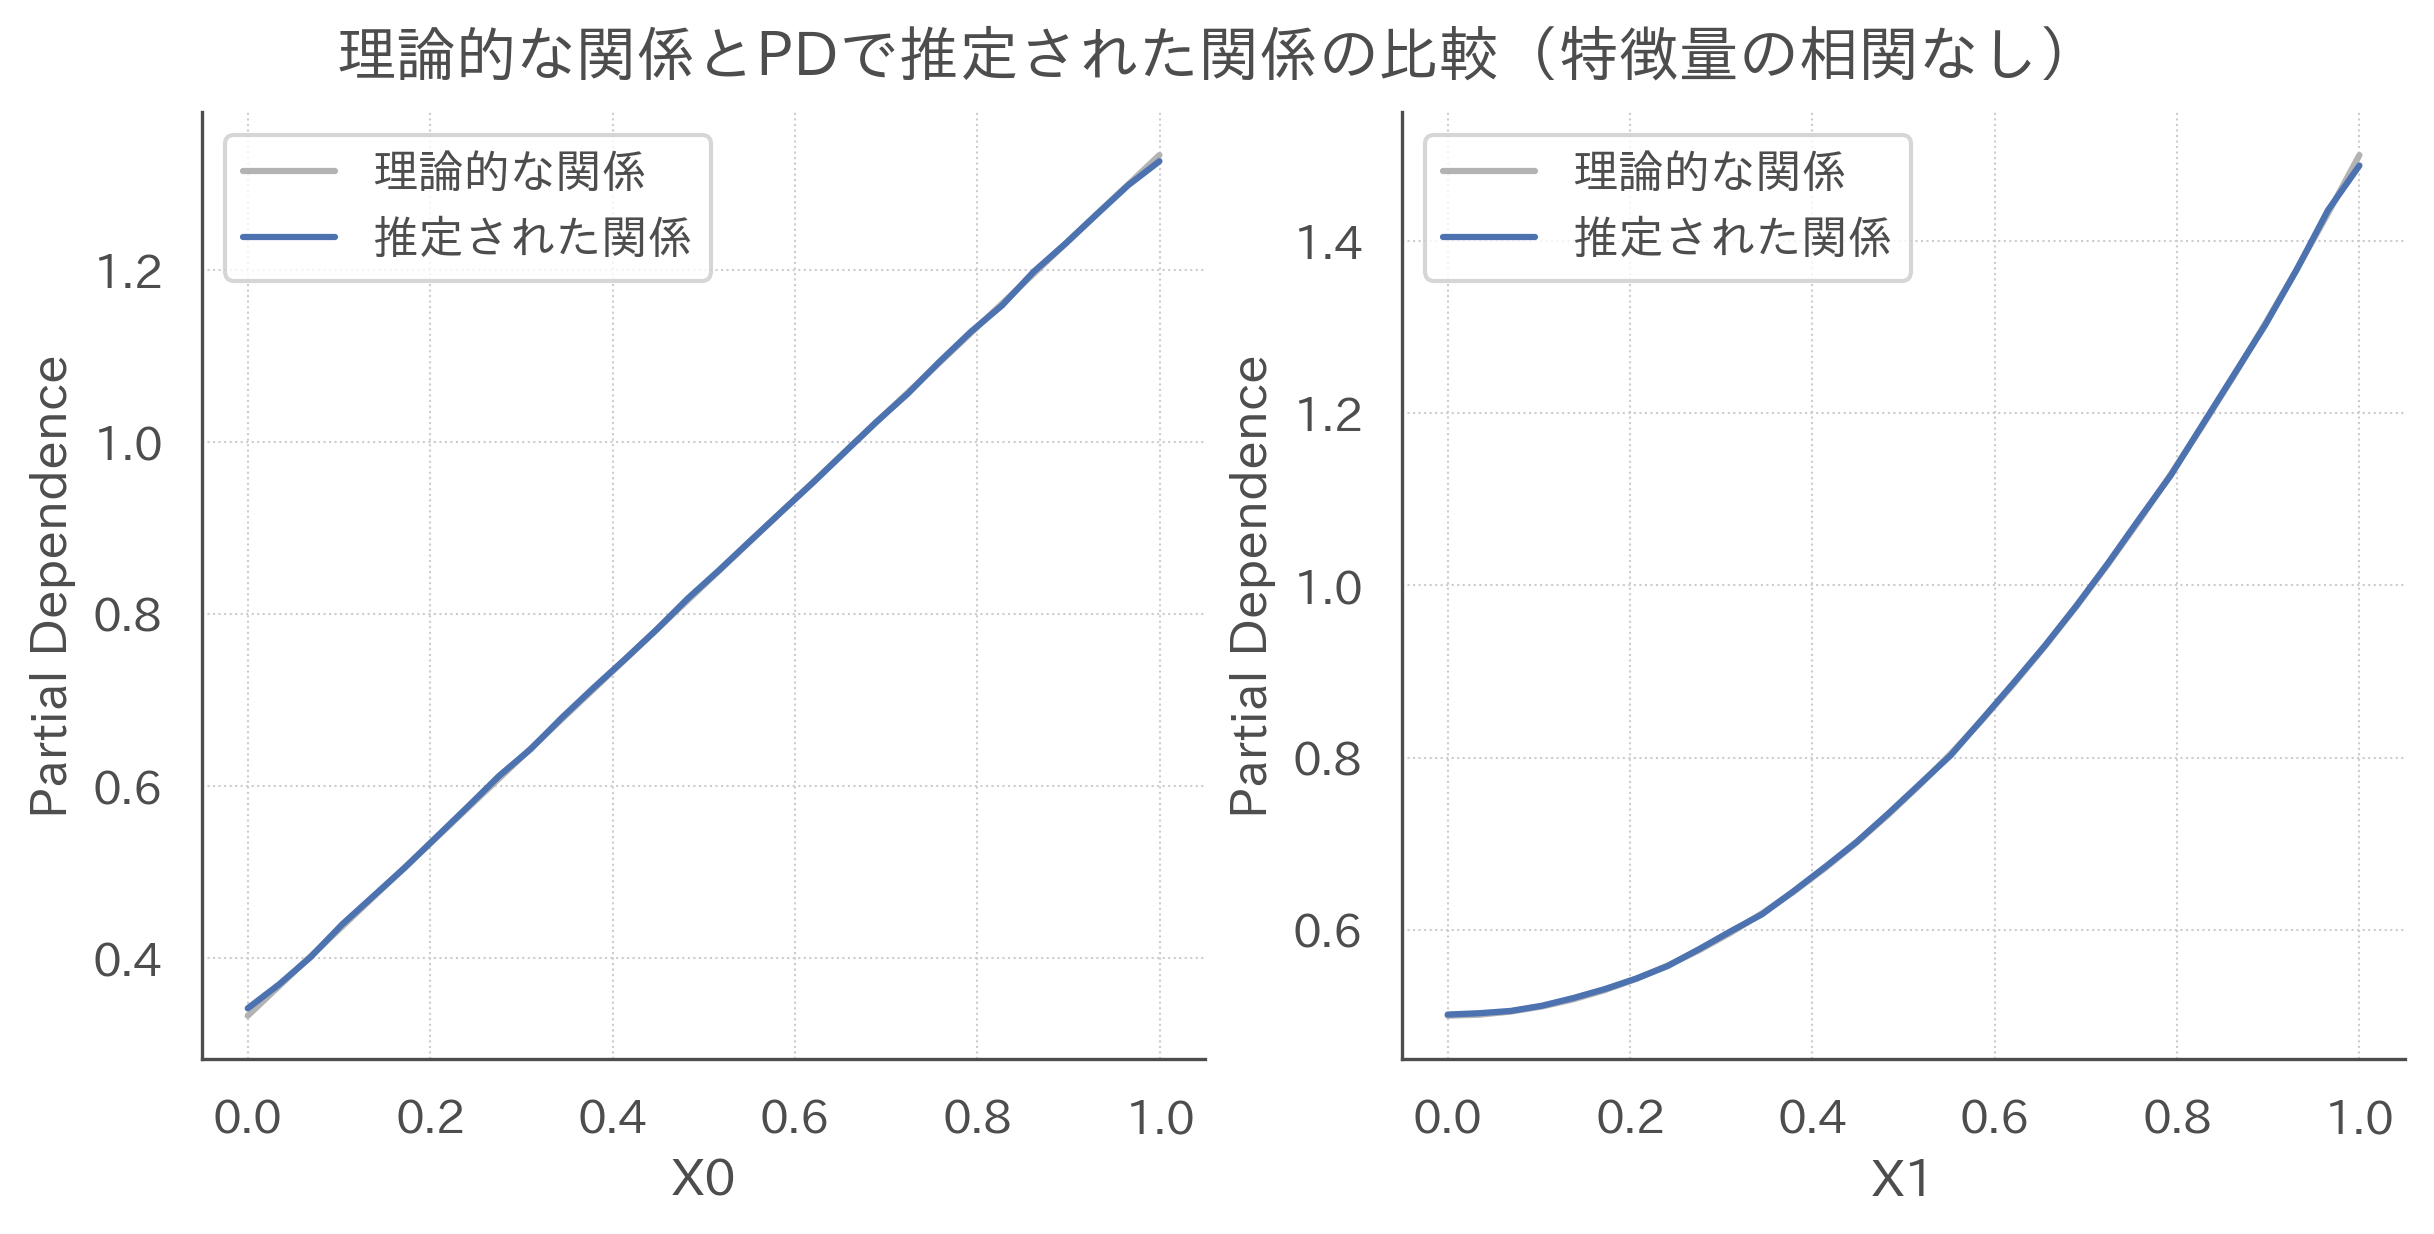

In [6]:
# Random Forestで予測モデルを構築
rf_indep = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_indep, y_indep)

# インスタンスを作成
pd_indep = PartialDependence(estimator=rf_indep, X=X_indep)

# PDを可視化
# fsには理論的な関係を与える
fs = [lambda x: x + 1 / 3, lambda x: x ** 2 + 0.5]
pd_indep.plot(
    fs=fs, ylabel="Partial Dependence", title="理論的な関係とPDで推定された関係の比較（特徴量の相関なし）"
)

重なっていてほぼ見えていませんが、グレーの線が理論的な関係、青い線がParital Dependenceによって推定された関係を表しています。
ふたつの線はほぼ一致しており、特徴量$(X_0, X_1)$共に、PDはうまく理論的な関係を捉えられていることが分かります。

### 特徴量が相関する場合

次に、特徴量が強く相関する場合を考えます。
特徴量$(X_0, X_1)$の相関係数を0.99としてシミュレーションデータを生成し、Random Forestで学習を行います。

In [7]:
# 特徴量が相関している場合のデータを生成
X, y = generate_simulation_data(rho=0.99)

# Random Forestで予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X, y)

PDで特徴量とモデルの予測値の関係を確認します。

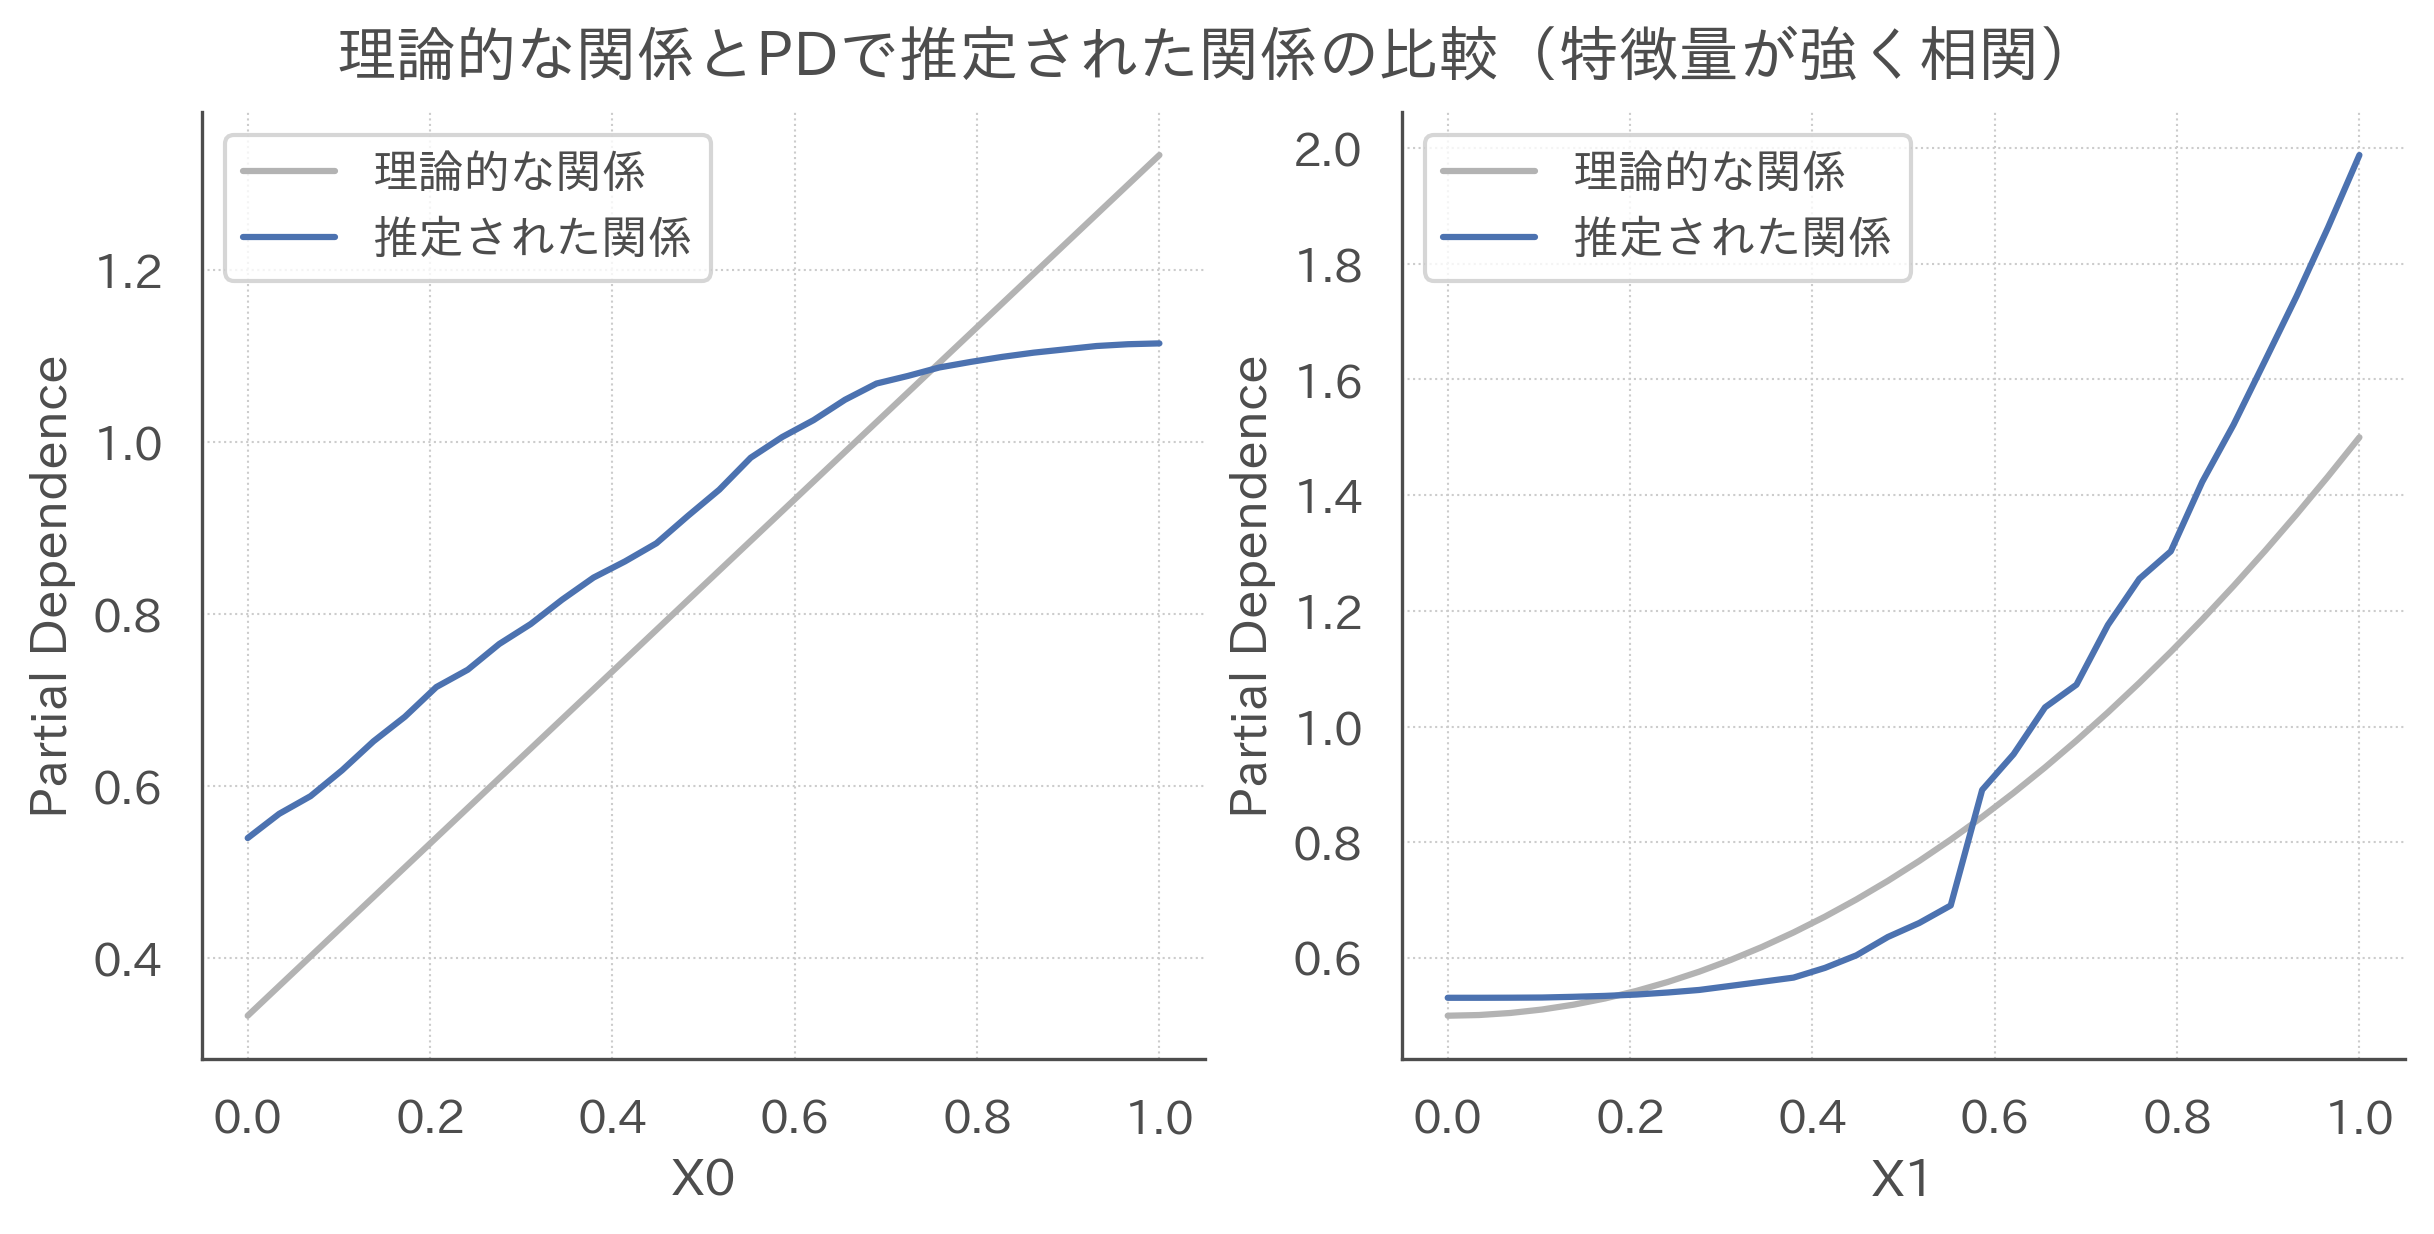

In [8]:
# インスタンスを作成
pd = PartialDependence(estimator=rf, X=X)

# PDを可視化
fs = [lambda x: x + 1 / 3, lambda x: x ** 2 + 0.5]
pd.plot(fs=fs, ylabel="Partial Dependence", title="理論的な関係とPDで推定された関係の比較（特徴量が強く相関）")

特徴量に相関がない場合とは異なり、特徴量に強い相関がある場合は、特徴量$(X_0, X_1)$共にPDによる推定結果は理論的な関係とズレが生じています。


### PDがうまく機能しない原因

特徴量が相関するとなぜPDがうまく機能しないのでしょうか。
結論を先に述べると、特徴量が相関している場合、いわゆる「外挿」の問題が起きてしまうことが原因です。
これを確認するために、特徴量$(X_0, X_1)$の散布図を作成します。
また、特徴量$(X_0, X_1)$に対する理論的なアウトカム$Y$の値が見て取れるように、等高線も可視化しておきます。

In [9]:
def draw_contour(
    ax: plt.Axes,
    X: np.ndarray,
    f1: Callable[[np.ndarray], np.ndarray],  # 等高線引くための関数
    f2: Callable[[np.ndarray], np.ndarray] | None = None,  # 2つまで指定可能
    xlabel: str | None = None,
    ylabel: str | None = None,
    title: str | None = None,
    cmaps: list[str] = ["viridis"],
) -> plt.Axes:
    """等高線プロット"""

    x = np.linspace(0, 1, num=50)

    ax.scatter(X[:, 0], X[:, 1], c=".8")

    z = f1(cartesian([x, x])).reshape(50, 50, order="F")
    CS = ax.contour(x, x, z, levels=10, cmap=cmaps[0])
    ax.clabel(CS, fmt="%1.2f")

    if f2 is not None:
        z = f2(cartesian([x, x])).reshape(50, 50, order="F")
        CS = ax.contour(x, x, z, levels=10, cmap=cmaps[1])
        ax.clabel(CS, fmt="%1.2f")

    ax.set(xlabel=xlabel, ylabel=ylabel, title=title)


def draw_contours(X: np.ndarray, model: Any, title: str | None = None) -> None:
    """等高線プロットを3つまとめる関数"""
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(4 * 3, 4))
    draw_contour(
        ax=axes[0],
        X=X,
        f1=f,
        xlabel="X0",
        ylabel="X1",
        title="特徴量(X0, X1)と理論値の関係",
    )
    draw_contour(
        ax=axes[1],
        X=X,
        f1=model.predict,
        xlabel="X0",
        ylabel="X1",
        cmaps=["magma"],
        title="特徴量(X0, X1)と予測値の関係",
    )
    draw_contour(
        ax=axes[2],
        X=X,
        f1=f,
        f2=model.predict,
        xlabel="X0",
        ylabel="X1",
        cmaps=["viridis", "magma"],
        title="特徴量(X0, X1)と理論値/予測値の関係",
    )

    fig.suptitle(title)
    fig.show()

まずは特徴量が相関していないケースを可視化します。

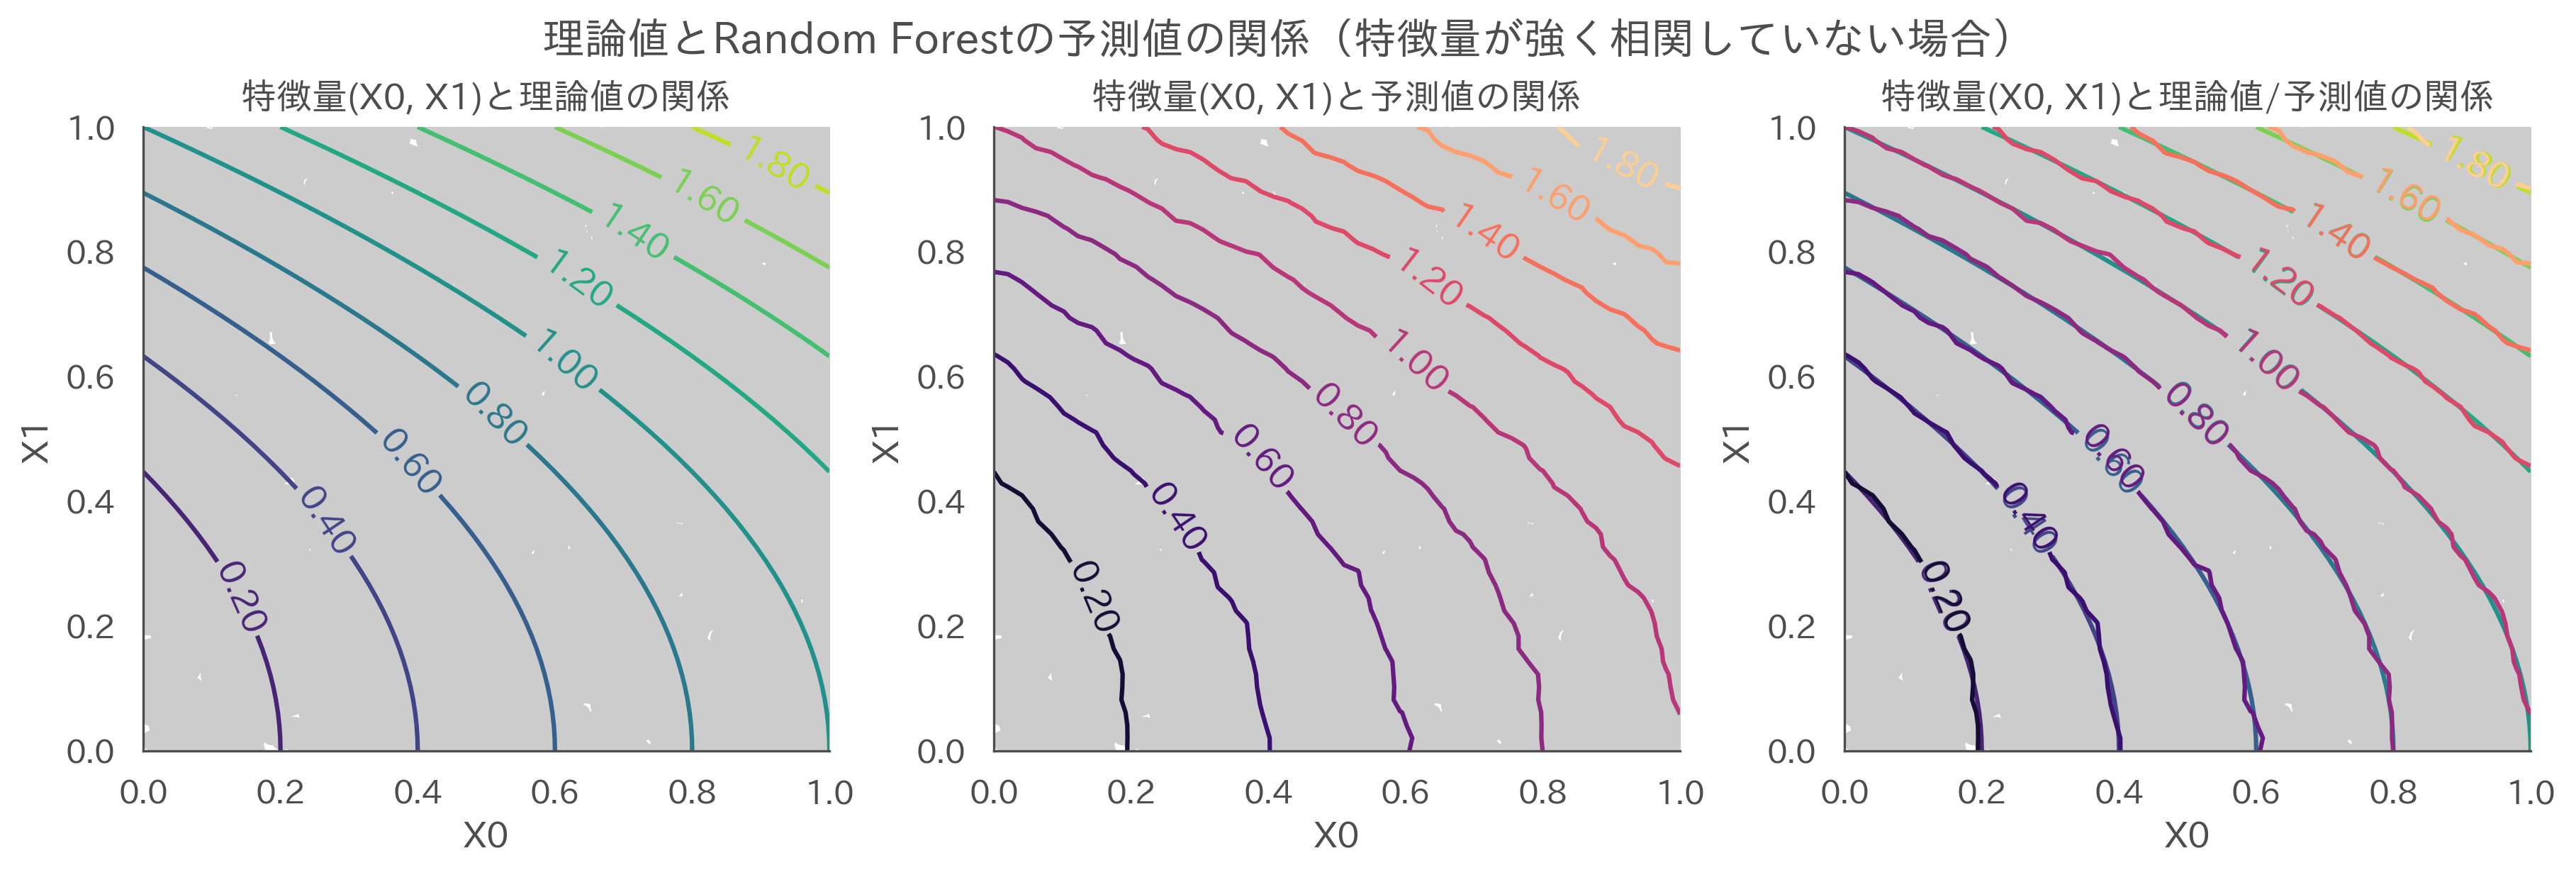

In [10]:
# 特徴量が相関していない場合の理論値と予測値の関係を可視化
draw_contours(
    X=X_indep, model=rf_indep, title="理論値とRandom Forestの予測値の関係（特徴量が強く相関していない場合）"
)

データはすべての範囲で均等に存在し、また理論値とモデルの予測値はすべての範囲で一致していることがわかります。

次に、特徴量が強く相関してる場合を可視化します。

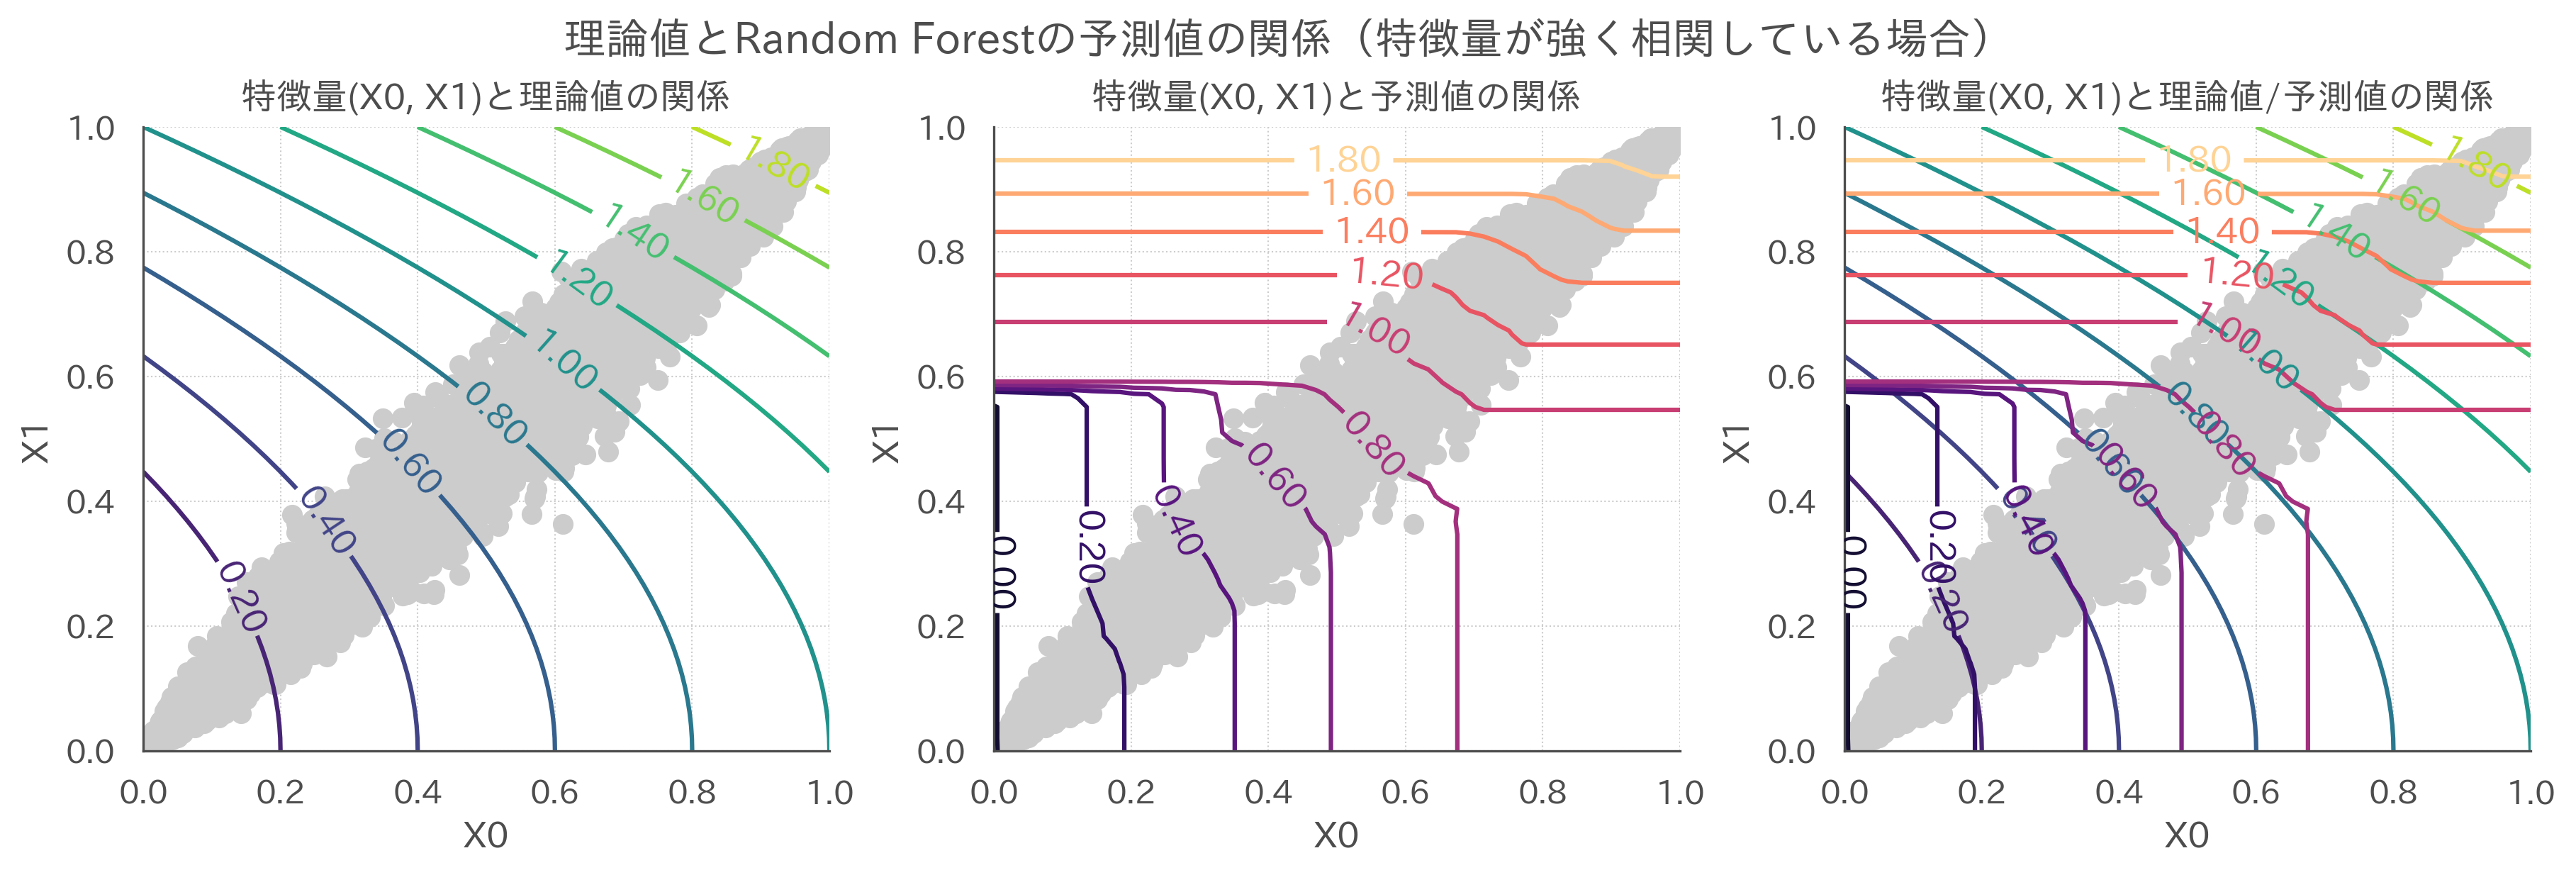

In [11]:
# 特徴量が相関している場合の理論値と予測値の関係を可視化
draw_contours(X=X, model=rf, title="理論値とRandom Forestの予測値の関係（特徴量が強く相関している場合）")

特徴量が相関しているので、画像の左上と右下の範囲にはデータが存在しません。
また、データの存在しない左上と右下の範囲では、Random Forestの予測値は理論的な値とズレが生じています。
これは外挿と呼ばれている問題で、訓練データに存在しない範囲での予測は一般にあまりうまくいきません。

この外挿問題がPDに悪影響を与えます。
特徴量$X_0$に対するPDを考えます。
$X_0 = 0.9$のときのPDは以下のように全インスタンスの予測値を平均して求めていました。
$$
\begin{align}
\widehat{\pd}_0(0.9) = \frac{1}{N}\sumi f(0.9, x_{i, 1})
\end{align}
$$
ここで問題になるのは、$X_0 = 0.9$のときは$X_1$が0から0.8くらいまでのインスタンスは実際には存在しないことです。
よって、実際には$(X_0, X_1) = (0.9, 0.2)$のような組み合わせのインスタンスは存在しないにもかかわらず、無理やり$f(0.9, 0.2)$という予測を行い、その結果を平均していることになります。
もちろん、このような特徴量の「ありえない」組み合わせに対してもうまく予測が行えるなら問題はないのですが、実際はこのような範囲での予測は往々にして精度が悪く、結果としてPDは理論的な関係をうまく捉えることができません。


特徴量に相関がある場合にPDが理論的な関係を復元できないことは事実ですが、データには存在しない特徴量の組み合わせに対してモデルがおかしな予測値を出すこともまた事実であり、その意味ではPDは「特徴量とモデルの予測値の関係」を捉えていると言えるかもしれません。
しかし、モデルの振る舞いを解釈するという観点では、データに存在しない特徴量の組み合わせに対するモデルの振る舞いではなく、データがきちんと存在する部分でのモデルの振る舞いを解釈したいというのが通常のモチベーションでしょう。
このモチベーションにおいては、特徴量が相関する場合はPDの結果をそのまま解釈するのは危険が伴います。

## Marginal Plot
### Marginal Plotの数式
PDがうまく機能しない原因は、データには存在しないような組み合わせの特徴量に対する予測値を使ってしまうことでした。
ということは、データが存在する範囲だけで期待値をとってあげればこの問題を回避できそうな気がします。
つまり、周辺分布$p(\vxmj)$を使って期待値
$$
\begin{align}
    \E{f(x_j, \vXmj)} = \int f(x_j, \vxmj)p(\vxmj)d\vxmj
\end{align}
$$
をとるのではなく、条件付き分布$p(\vxmj | x_j)$を使って条件付き期待値
$$
\begin{align}
    \E{f(x_j, \vXmj)\mid X_j = x_j} = \int f(x_j, \vxmj)p(\vxmj | x_j)d\vxmj
\end{align}
$$
をとればうまくいくかもしれません。
この条件付き期待値を用いた可視化はMarginal Plotと呼ばれています。

残念なことに、この手法は理論的な関係をうまく復元できないことがわかっています。
極端な例として、$f(X_0, X_1) = X_0 + X_1^2$で、特徴量$(X_0, X_1)$が完全に相関しているケース、つまり$X_0 = X_1$のケースを考えます。
このとき、特徴量$X_0$に対するMarginal Plotの理論値は以下になります。
$$
\begin{align}
    \mathrm{M}_0(x_0) 
    &= \E{f(x_0, X_1) \mid X_0 = x_0}\\
    &= \E{x_0 + X_1^2  \mid X_0 = x_0}\\
    &= x_0 + \E{X_1^2  \mid X_0 = x_0}\\
    &= x_0 + x_0^2
\end{align}
$$
同様に、特徴量$X_0$に対する理論値は以下になります。
$$
\begin{align}
    \mathrm{M}_1(x_1) 
    &= \E{f(X_0, x_1) \mid X_1 = x_1}\\
    &= \E{X_0 + x_1^2\mid X_1 = x_1}\\
    &= \E{x_0\mid X_1 = x_1} + x_1^2\\
    &= x_1 + x_1^2
\end{align}
$$

ここから分かるように、特徴量が完全に相関している場合、Marginal Plotでは特徴量$(X_0, X_1)$の効果が完全に混ざってしまっています。
話を簡単にするために特徴量が完全に相関しているという極端なケースを考えましたが、一般的に、相関が強いほど特徴量の効果が混ざり合う度合いが強くなります。
<!-- 実際、特徴量$(X_0, X_1)$が共に正規分布に従っているとすると、$X_0 = x_0$のときの$X_1$の条件付き分布は
$$
    p(x_1 \mid x_0) = \mathcal{N}\paren{\mu_1 + \rho\frac{\sigma_1}{\sigma_0}\paren{x_0 - \mu_0},\; \sigma_1^2\paren{1-\rho^2}}
$$
であり、相関が強いほど -->

### Marginal Plotのアルゴリズム
理論的には、Marginal Plotはあまりうまく行かなさそうなことがわかりましたが、一応、Marginal Plotを作成するためのアルゴリズムを考えてみましょう。
条件付き分布$p(x_j \mid \vxmj)$はちゃんと推定しようとすると難しいですが、手っ取り早いやり方として、特徴量$X_j$の値の範囲をいくつかのブロックに分割して、そこに含まれるインスタンスのみを利用して予測値を出し、平均することにします。

つまり、Marginal Plotを計算するアルゴリズムは以下になります。
1. 特徴量$X_j$の値の取りうる範囲を$[x_j^{(0)}, x_j^{(1)}),\; [x_j^{(1)}, x_j^{(2)}),\; \dots,\; [x_j^{(k-1)}, x_j^{(k)})\dots,\;[x_j^{(K-1)}, x_j^{(K)}]$のように$K$個のブロックに分割する。ここで、$x_j^{(0)}$と$x_j^{(K)}$は特徴量$X_j$が取りうる値の最小値と最大値を表す。範囲が$[x_j^{(k-1)}, x_j^{(k)})$であるブロックをブロック$k$と呼ぶ
1. ブロック$k$に対して、特徴量$X_j$の値がそのブロックの区間$[x_j^{(k-1)}, x_j^{(k)})$に入っているインスタンスを抜き出してきて、$X_j$の値を$\frac{1}{2}\paren{x_j^{(k-1)} + x_j^{(k)}}$に置き換えたの場合の予測値を求めて平均する。つまり、
$$
   \frac{1}{N^{(k)}} \sum_{i: x_{j}^{(k-1)} \leq x_{i, j} < x_{j}^{(k)}} f\paren{\frac{x_j^{(k-1)} + x_j^{(k)}}{2}, \vximj}
$$
を計算する。ここで、$N^{(k)}$はブロック$k$に含まれるインスタンスの総数を表す
1. 2の操作を全ての$k = 1, \dots, K$に対して行う


例えば、特徴量$X_0$は区間$[0, 1]$に分布しているので、これを$[0, 0.1),\; [0.1, 0.2),\; \dots,\; [0.9, 1]$に分割します。区間$[0.1, 0.2)$について考えると、特徴量$X_0$の値が区間$[0.1, 0.2)$に含まれるインスタンスを持ってきて、$X_0$の値を0.15に置き換えたのときの予測値を出し、平均します。

### Maginal Plotの実装
実際にMarginal Plotのアルゴリズムを実装してみましょう。
先程実装した`PartialDependence`クラスを継承して、`_estimate_relationship()`メソッドを上記のアルゴリズムでオーバーライドすればOKです。

In [12]:
class Marginal(PartialDependence):
    """Marginal Plot"""

    def _estimate_relationship(
        self, j: int, n_grid: int = 30
    ) -> tuple[np.ndarray, np.ndarray]:
        """Marginal Predictionを求める

        Args:
            j: Marginal Predictionを計算したい特徴量のインデックス
            n_grid: グリッドを何分割するか
        Returns:
            特徴量の値とその場合のMarginal Prediction
        """

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        # 全てのブロックに同じ数だけのインスタンスが入るようにする
        xjks = np.quantile(self.X[:, j], q=np.arange(0, 1, 1 / n_grid))

        # ブロックごとに平均的な予測値を求める
        marginals = np.zeros(n_grid)
        for k in range(1, n_grid):
            mask = (self.X[:, j] >= xjks[k - 1]) & (self.X[:, j] <= xjks[k])

            marginals[k] = self._predict_average(
                self.X[mask], j, (xjks[k - 1] + xjks[k]) / 2
            )

        return (xjks, marginals)

実装した`Marginal`クラスを使って、Marginal Plotを作成します。

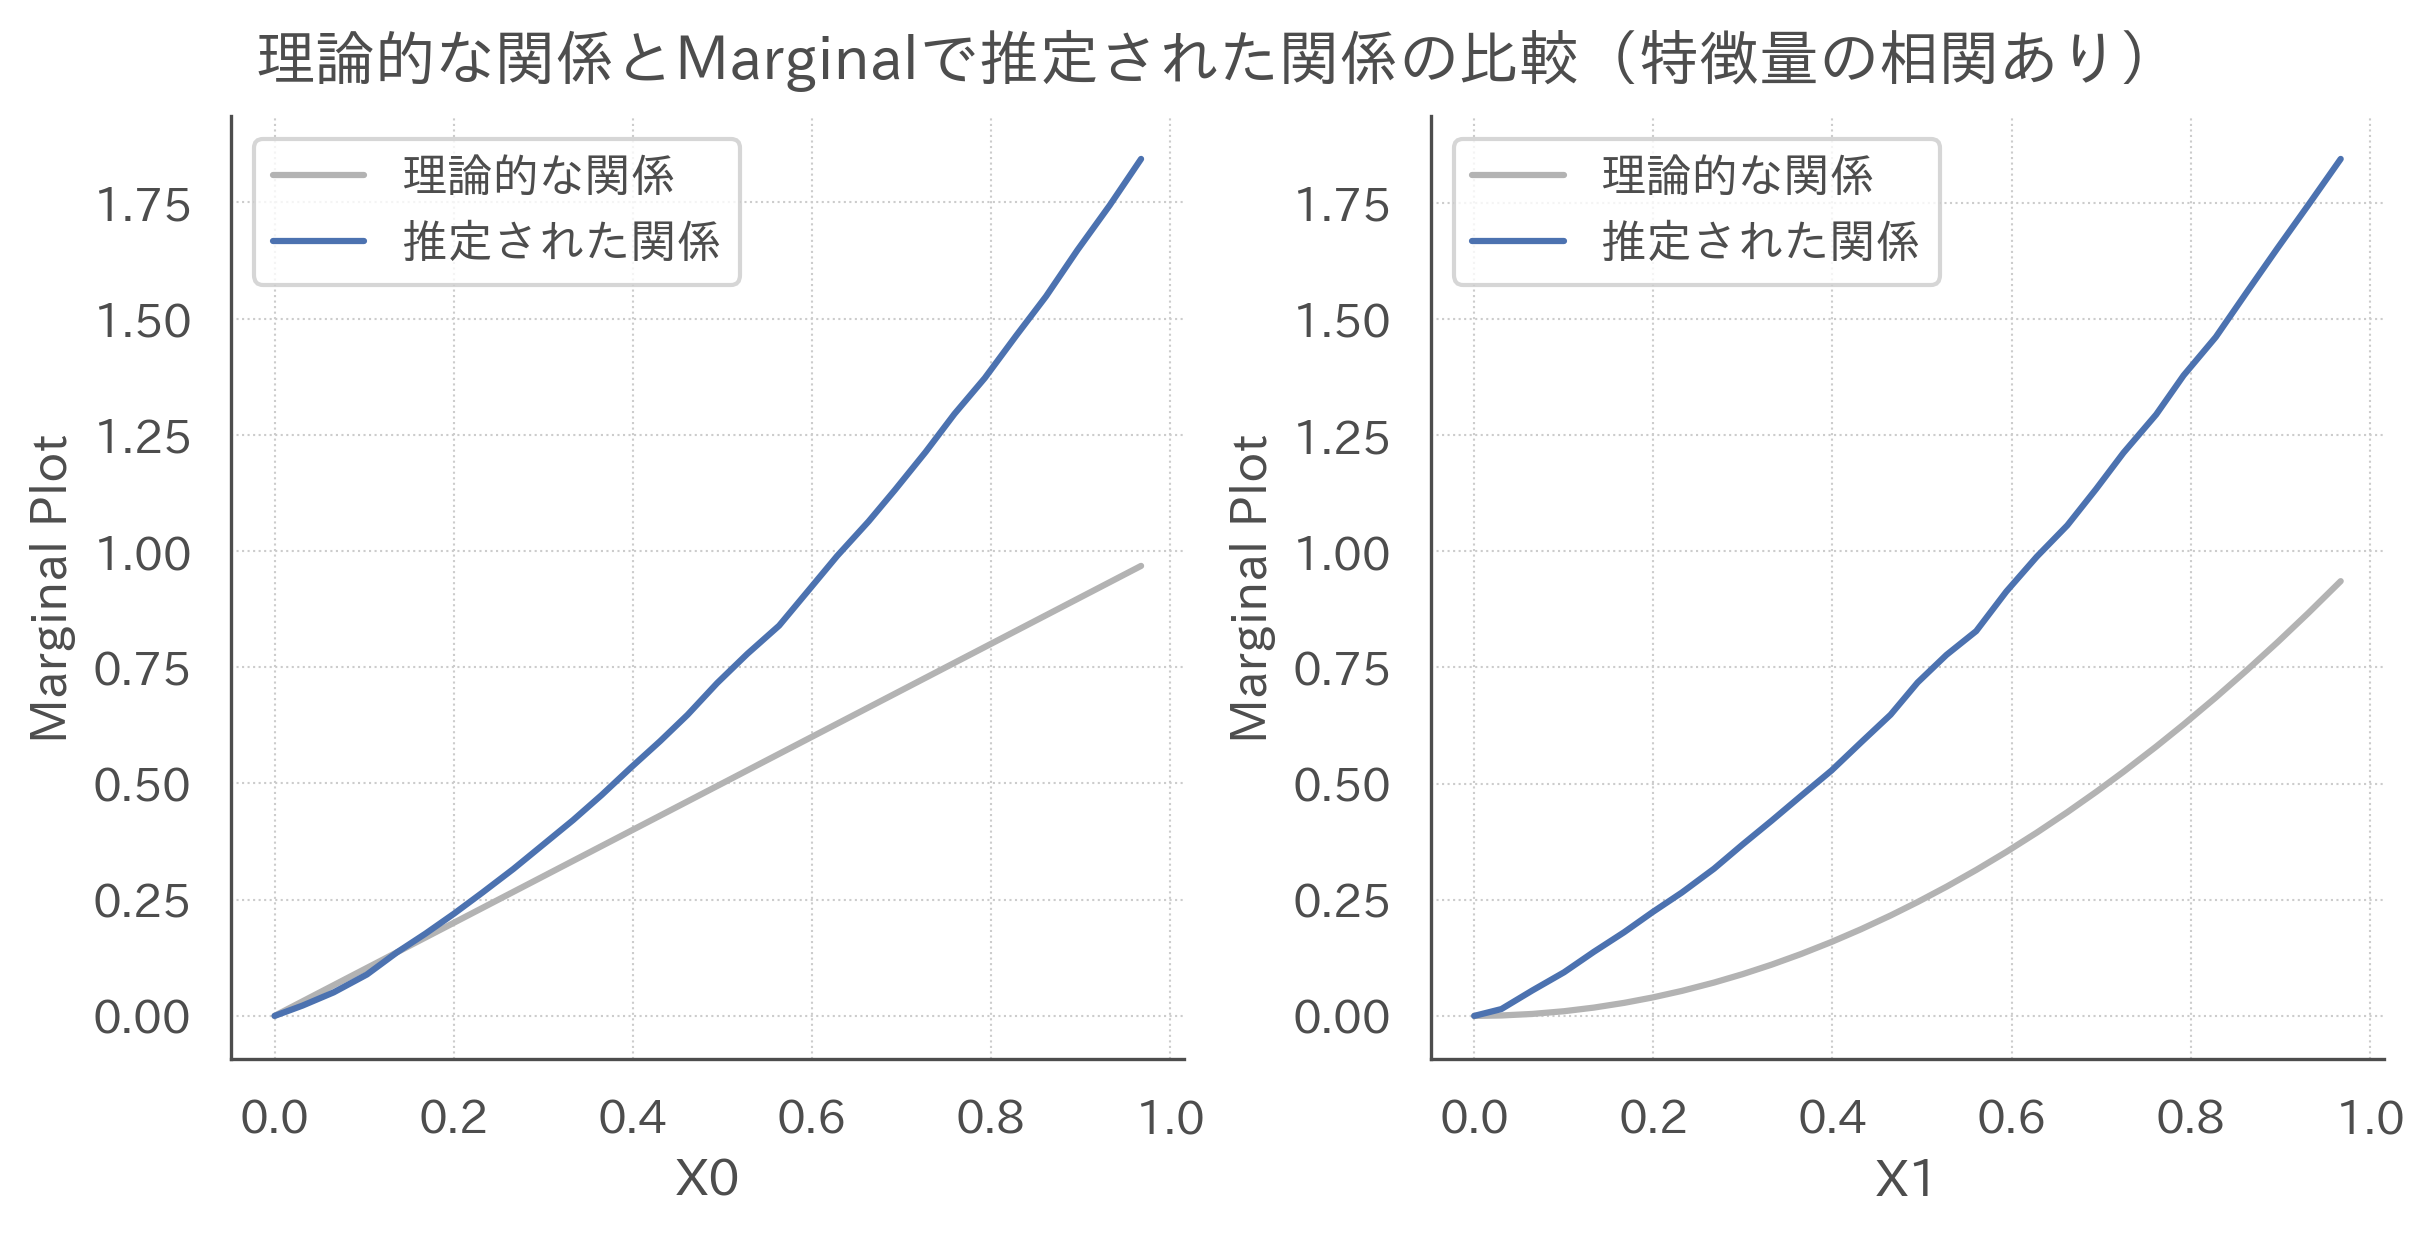

In [13]:
# インスタンスを作成
m = Marginal(estimator=rf, X=X)

# 可視化
fs = [lambda x: x, lambda x: x ** 2]
m.plot(fs=fs, ylabel="Marginal Plot", title="理論的な関係とMarginalで推定された関係の比較（特徴量の相関あり）")

数式でも確認したように、特徴量$(X_0, X_1)$のどちらも関係が$x + x^2$として可視化されています。
今回知りたいのは個別の特徴量と予測値の関係なので、特徴量$(X_0, X_1)$の効果が混ざってしまうMarginal Plotはこの用途にはあまり適しているは言えません。

## Accumulated Local Effects
### ALEのアイデア
さて、PDのように期待値をとってもだめ、Marginal Plotのように条件付き期待値をとってもだめだとすると、特徴量が相関する場合に特徴量と予測値の関係をどうやって解釈すればよいのでしょうか。

実は、この問題を解決する手法として、Accumulated Local Effects（ALE）が提案されています。

ALEは、Marginal Plotと同じく、特徴量$X_j$の値の範囲をいくつかのブロックに分割して、そこに含まれるインスタンスのみを対象にする手法です。
ただし、Marginal Plotはその区間での「平均的な予測値」に注目していましたが、ALEではその区間の両端での「予測値の差分」に注目します。

何を言っているかわからないと思うので、もう少し丁寧に説明させてください。
話を簡単にするために、下図のような特徴量がひとつのケースを考えます。

![](figure/スライド1.png)

特徴量$X$の区間を$[x^{(0)}, x^{(1)}),\;[x^{(1)}, x^{(2)}),\;[x^{(2)}, x^{(3)}), \dots$と分割しています。
ここで、区間$[x^{(0)}, x^{(1)})$に注目すると、両端での予測値の差分は$f(x^{(1)}) - f(x^{(0)})$で求まります。
同様にして、区間$[x^{(1)}, x^{(2)})$での予測値の差分は$f(x^{(2)}) - f(x^{(1)})$、区間$[x^{(2)}, x^{(3)})$での予測値の差分は$f(x^{(3)}) - f(x^{(2)})$のように計算していくことができます。
また、このようにして求めた区間ごとの予測値の差分$f(x^{(k)}) - f(x^{(k-1)})$を累積（Accumulate）していくことで、理論的な関係を復元することができそうです。
区間ごとの予測値の差分を、この区間における特徴量が与えた効果（Local Efffect）と解釈し、その効果を累積（Accumulate）するので、この手法はAccumulated Local Effectsと呼ばれています。

さて、ALEが特徴量と予測値の関係を捉えられそうな雰囲気がでてきましたが、これは特徴量が相関するケースでもうまく機能するのでしょうか。
これまで考えたきたシミュレーションデータのように、特徴量$(X_0, X_1)$に強い相関が見られるケースを考えます。
特徴量$X_0$とモデルの予測値の関係を解釈したいとします。
特徴量がひとつのケースと同様に、特徴量$X_0$の区間を$[x^{(0)}_0, x^{(1)}_0),\;[x^{(1)}_0, x^{(2)}_0),\;[x^{(2)}_0, x^{(3)}_0), \dots$と分割します。
あとは各区間の両端での予測値の差分を計算すると、その区間で特徴量$X_0$の効果が計算できます。

![](figure/スライド2.png)

具体的に、上図のような状況を考えます。
上図では、区間$[x^{(1)}_0, x^{(2)}_0)$に含まれているインスタンスを4つ抜き出しています（上から順にインスタンス0、インスタンス1、インスタンス2、インスタンス3とします）。

これらのインスタンスに対して、ALEは下図のような計算を行います。
![](figure/スライド3.png)

区間$[x^{(1)}_0, x^{(2)}_0)$に含まれているインスタンスに対して、そのインスタンスの特徴量$X_1$の値は固定しておいて、特徴量$X_0$のみ区間の両端の値に置き換えて予測値の差分を計算します。
$$
\begin{align}
   f(x_0^{(2)}, x_{i, 1}) - f(x_0^{(1)}, x_{i, 1})
\end{align}
$$
これをこの区間に含まれるすべてのインスタンスに対して行い、結果を平均することで、この区間における特徴量$X_0$のLocal Effectを計算することができます。

### ALEはうまく機能するのか

さて、ALEの計算方法はわかりましたが、特徴量が相関するケースでもALEはうまく機能するのでしょうか。
これを確認するため、具体的に$f(X_0, X_1) = X_0 + X_1^2$のケースを考えます。
この場合、インスタンス$i$の特徴量$X_0$に関するLocal Effectは
$$
\begin{align}
   f(x_0^{(2)}, x_{i, 1}) - f(x_0^{(1)}, x_{i, 1}) 
   &= \paren{x_0^{(2)} + x_{i, 1}^2} - \paren{x_0^{(1)} + x_{i, 1}^2}\\
   &= x_0^{(2)} - x_0^{(1)}
\end{align}
$$
であり、特徴量$X_1$の影響を完全に消し飛ばして特徴量$X_0$の効果を純粋に取り出せていることがわかります（特徴量$X_0$が1大きくなるとモデルの予測値も1大きくなる）。
また、ALEの計算には区間$[x^{(1)}_0, x^{(2)}_0)$に含まれているインスタンスのみを用いるため、PDで起きていたような外挿の影響も受けません。
よって、特徴量が相関するケースでも、ALEは特徴量とモデルの予測値の関係をうまく捉えることができそうです。

ただし、この結果は$f(X_0, X_1) = f_0(X_0) + f_1(X_1)$のように交互作用のない場合にのみ通用します。
交互作用がある場合にALEがどのように振る舞うかはApley and Zhu(2020)や"Limitations of Interpretable Machine Learning Methods"をご確認ください。

### ALEのアルゴリズム

特徴量が2つのケースを用いてALEのアイデアを把握できたので、特徴量が$J$個の場合に一般化したアルゴリズムも確認しておきます。
記号がややこしくなっていますが、やっていることは先程の特徴量が2つの場合と同じです。

1. 特徴量$X_j$の値の取りうる範囲を$[x_j^{(0)}, x_j^{(1)}),\; [x_j^{(1)}, x_j^{(2)}),\; \dots,\; [x_j^{(k-1)}, x_j^{(k)})\dots,\;[x_j^{(K-1)}, x_j^{(K)}]$のように$K$個のブロックに分割する。ここで、$x_j^{(0)}$と$x_j^{(K)}$は特徴量$X_j$が取りうる値の最小値と最大値を表す。範囲が$[x_j^{(k-1)}, x_j^{(k)})$であるブロックをブロック$k$と呼ぶ
1. ブロック$k$に対して、特徴量$X_j$の値がそのブロックの区間$[x_j^{(k-1)}, x_j^{(k)})$に入っているインスタンスを抜き出してきて、$X_j$の値を$x_j^{(k-1)}$と$x_j^{(k)}$に置き換えたの場合の予測値の差分を求めて平均する。つまり、
$$
\begin{align}
   \frac{1}{N^{(k)}} \sum_{i: x_{j}^{(k-1)} \leq x_{i, j} < x_{j}^{(k)}} \paren{f\paren{x_j^{(k)}, \vximj} - f\paren{x_j^{(k-1)}, \vximj}}
\end{align}
$$
を計算する。ここで、$N^{(k)}$はブロック$k$に含まれるインスタンスの総数を表す。これをLocal Effectと呼ぶ
1. 2の操作を全ての$k = 1, \dots, K$に対して行う
1. 求めたLocal Effectを累積する

### ALEの実装
実際にALEのアルゴリズムを実装してみましょう。
これも`Marginal`クラスと同じく、`PartialDependence`クラスを継承して`_estimate_relationship()`メソッドを上記のアルゴリズムでオーバーライドすればOKです。

In [14]:
class AccumulatedLocalEffects(PartialDependence):
    """Accumulated Local Effects Plot(ALE)"""

    def _estimate_relationship(
        self, j: int, n_grid: int = 30
    ) -> tuple[np.ndarray, np.ndarray]:
        """ALEを求める

        Args:
            j: ALEを計算したい特徴量のインデックス
            n_grid: グリッドを何分割するか
        Returns:
            特徴量の値とその場合のALE
        """

        # ターゲットの変数を、取りうる値の最大値から最小値まで動かせるようにする
        xjks = np.quantile(self.X[:, j], q=np.arange(0, 1, 1 / n_grid))
        
        # 区間ごとに両端での予測値の平均的な差分を求める
        local_effects = np.zeros(n_grid)
        for k in range(1, n_grid):
            mask = (self.X[:, j] >= xjks[k - 1]) & (self.X[:, j] <= xjks[k])

            local_effects[k] = self._predict_average(
                self.X[mask], j, xjks[k]
            ) - self._predict_average(self.X[mask], j, xjks[k - 1])

        accumulated_local_effects = np.cumsum(local_effects)

        return (xjks, accumulated_local_effects)

実装した`AccumulatedLocalEffects`クラスを使って、ALEを可視化します。

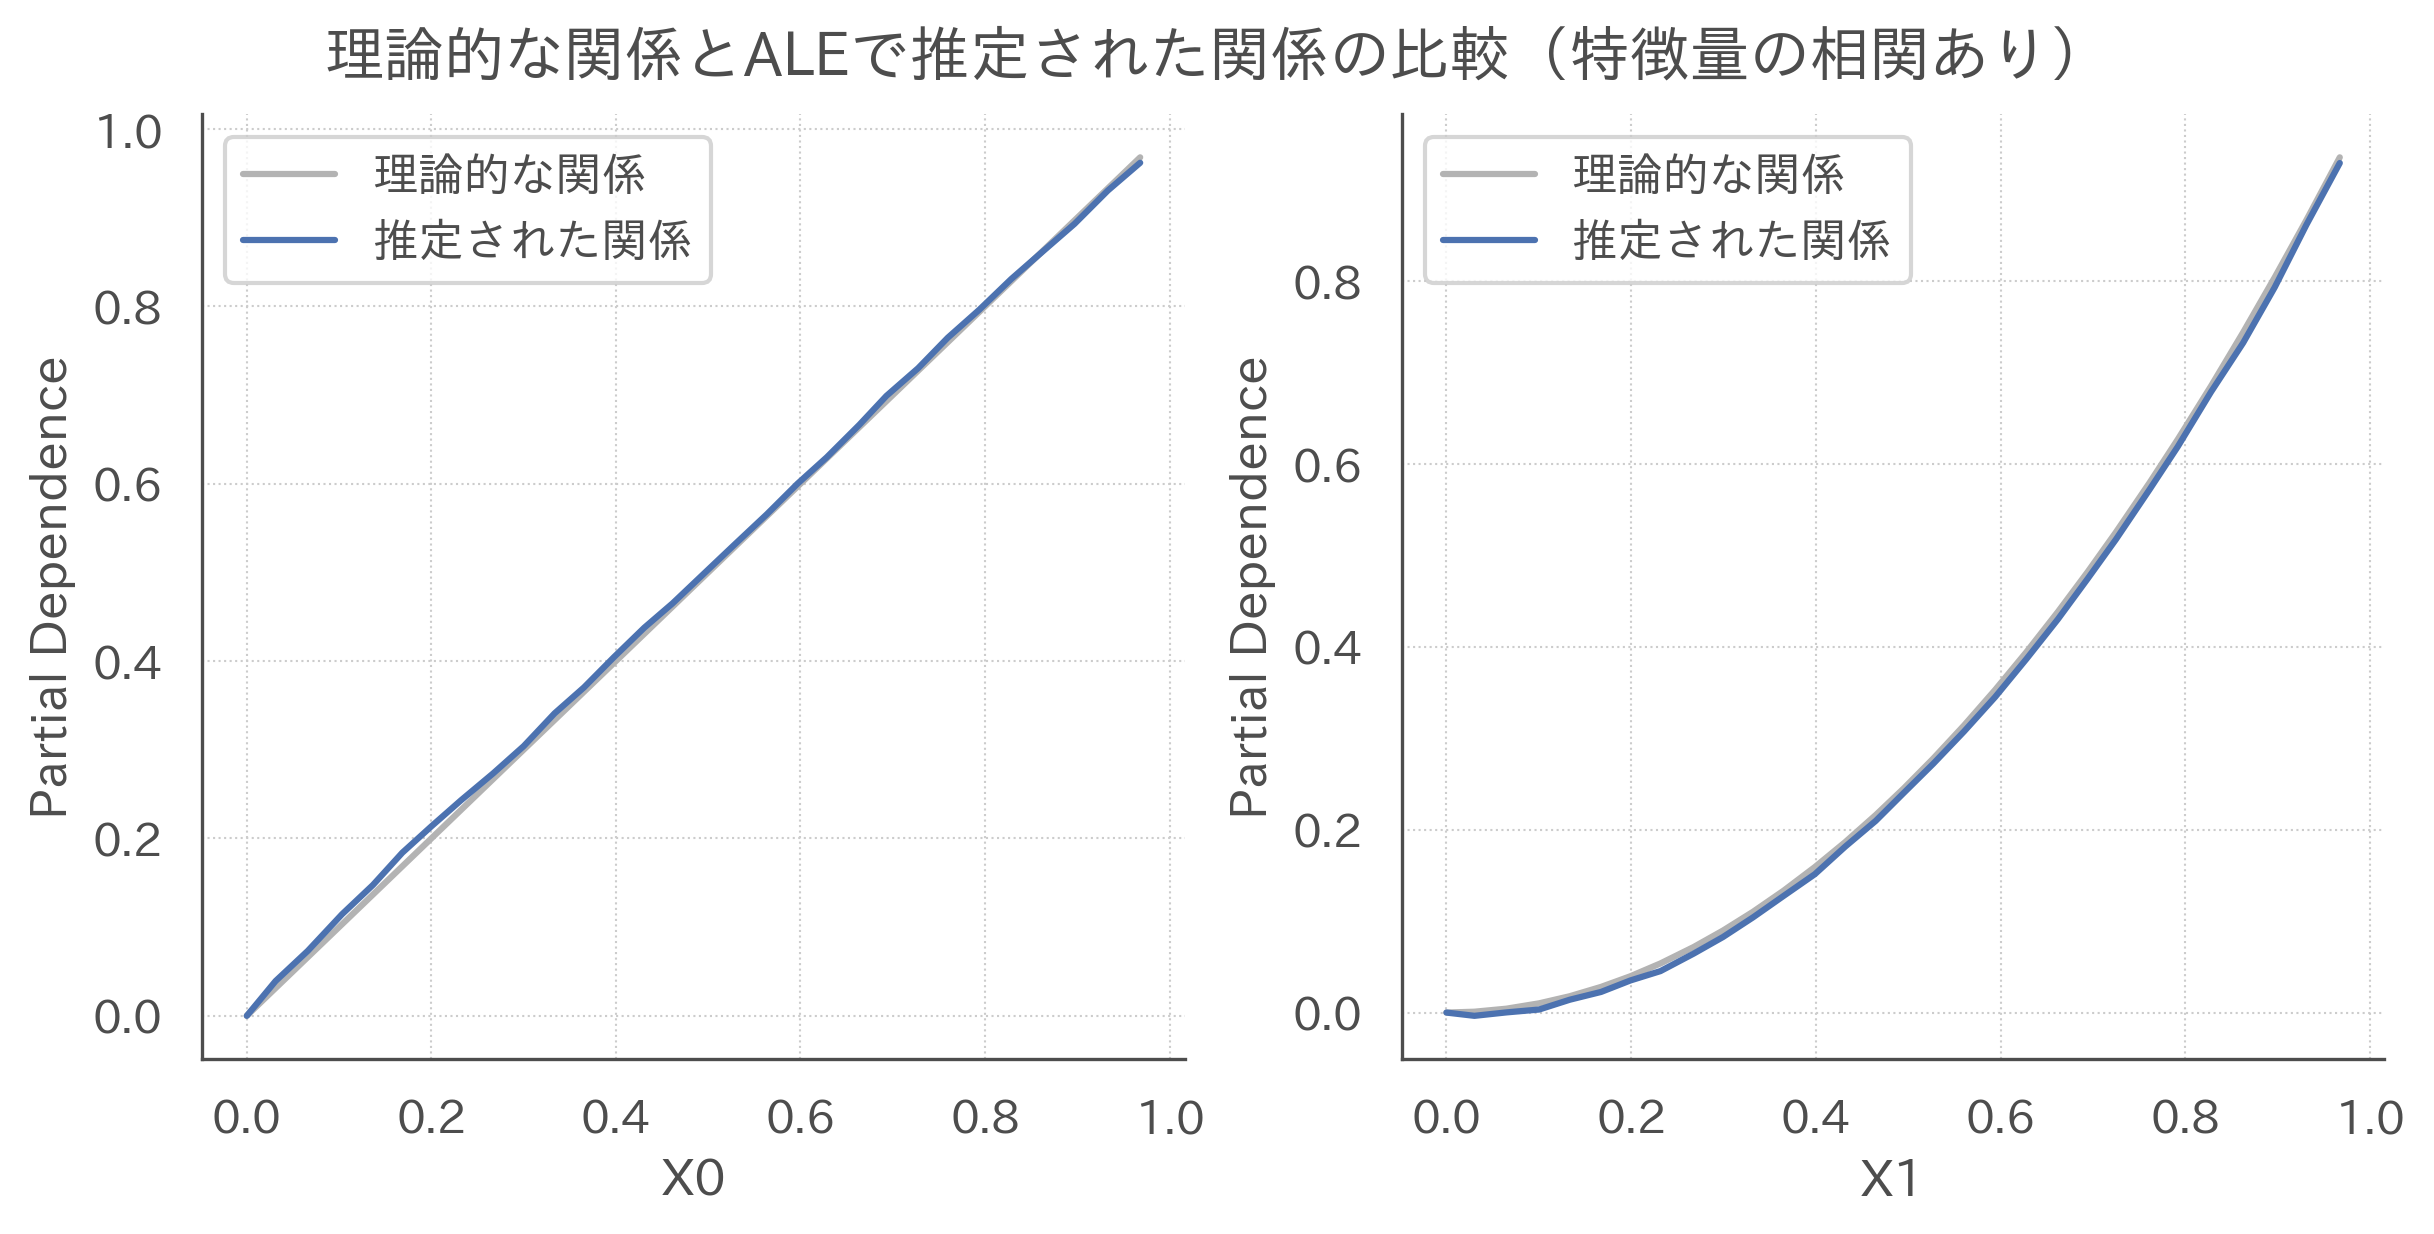

In [15]:
ale = AccumulatedLocalEffects(estimator=rf, X=X)
fs = [lambda x: x, lambda x: x ** 2]
ale.plot(fs=fs, ylabel="Partial Dependence", title="理論的な関係とALEで推定された関係の比較（特徴量の相関あり）")

特徴量が強く相関する場合、PDはやMarginal Plotでは理論的な関係をうまく捉えることができませんでしたが、ALEはこの問題を克服できていることがわかります。

### ALEの数式
最後に、ALEの数式による表現も確認しておきます。
実際のデータからALEを計算する際には、特徴量$X_j$の区間を分割してその中での特徴量$X_j$が与える効果を計算し、それを累積していました。
理論的には、この区間を細かくするほどより正確な近似を行うことができるはずです。

特徴量$X_j$が微小に変化した際の効果は微分を用いることで表現できます。
$$
\begin{align}
\frac{\partial f(X_j, \vXmj)}{\partial X_j} 
\end{align}
$$

$X_j = z_j$で条件づけた場合の$\partial f(X_j, \vXmj)/\partial X_j$の期待値を計算することで、$X_j = z_j$におけるLocal Effectを知ることができます。
$$
\begin{align}
    \E{\frac{\partial f(X_j, \vXmj)}{\partial X_j} \mid X_j = z_j}
\end{align}
$$

このLocal Effectを最小値$x_j^{(0)}$から累積していくことで、ALEを求めることができます。
累積は積分で計算できます。
$$
\begin{align}
    \ale_j(x_j) = \int_{x_j^{(0)}}^{x_j} \E{\frac{\partial f(X_j, \vXmj)}{\partial X_j} \mid X_j = z_j}dz_j
\end{align}
$$

実際に$f(X_0, X_1) = X_0 + X_1^2$の場合にALEの理論値を計算してみましょう。
まず、特徴量$X_0$に対するALEを求めます。
$$
\begin{align}
    \ale_0(x_0) 
    &= \int_{0}^{x_0} \E{\frac{\partial \paren{X_0 + X_1^2}}{\partial X_0} \mid X_0 = z_0}dz_0\\
    &= \int_{0}^{x_0} \E{1 \mid X_0 = z_0}dz_0\\
    &= \int_{0}^{x_0} 1dz_0\\
    &= x_0
\end{align}
$$
ALEが理論的な関係をうまく捉えられていることがわかります。
次に、特徴量$X_0$に対するALEを求めます。
$$
\begin{align}
    \ale_1(x_1) 
    &= \int_{0}^{x_1} \E{\frac{\partial \paren{X_0 + X_1^2}}{\partial X_1} \mid X_1 = z_1}dz_1\\
    &= \int_{0}^{x_1} \E{2X_1 \mid X_1 = z_1}dz_1\\
    &= \int_{0}^{x_1} 2z_1dz_1\\
    &= x_1^2
\end{align}
$$
こちらも同様に、ALEが理論的な関係をうまく捉えられていることがわかります。

## まとめ

この記事では、特徴量に相関があるとPDがなぜうまく機能しないのかを説明し、問題を解決する手法としてAccumulated Local Effects（ALE）を紹介しました。

- PDは特徴量とモデルの予測値の関係を知ることができる有用な解釈手法だが、特徴量が強く相関する場合はあまりうまく機能しない。データには存在しない特徴量の組み合わせに対して無理やり予測した結果を利用することが原因（外挿問題）
- この問題を単純に回避しようとする手法にMarginal Plotがあるが、うまくいかない。Marginal Plotでは相関する特徴量の効果が混ざってしまう
- ALEは特徴量が強く相関する場合でも、（データが存在する範囲での）特徴量をとモデルの予測値の関係をうまく解釈することができる

ただし、ALEはあくまで平均的な効果を解釈しており、インスタンスごとの解釈を行うことはできません。
もちろん平均的な効果を知ることは重要ですが、特徴量が予測値に与える影響はインスタンスの属性によって大きく異なる可能性があります。
このようなインスタンスごとの解釈性が必要な場合はIndividual Conditional Expectation（ICE）を用いて解釈を行う必要があります。
ICEについての解説はこの記事では行わないので、森下(2021)やMolnar(2019)をご確認ください。

## Appendix：線形回帰モデルの場合

特徴量が強く相関する場合、データには存在しない特徴量の組み合わせに対して無理やり予測した結果を利用することがPDがうまく機能しない原因でした。
ですので、外挿の場合もうまく予測ができるなら、特徴量が強く相関していてもPDはうまく機能します。

実際にこれを確認するため、Random Forestではなく線形回帰モデルを利用してみましょう。
具体的に、線形回帰モデル
$$
\begin{align}
Y = \beta_0X_0 + \beta_1X_1^2 + \epsilon
\end{align}
$$
を考えます。

In [16]:
class Preprocessor(BaseEstimator, TransformerMixin):
    """特徴量X1を二乗するだけの前処理クラス"""

    def fit(self, X: np.ndarray, y=None):
        # 　特になにもしない
        return self

    def transform(self, X: np.ndarray) -> np.ndarray:
        _X = X.copy()  # 直接の書き換えが起きないように
        _X[:, 1] = _X[:, 1] ** 2  # 特徴量X1を二乗した値にする

        return _X


# 線形回帰モデルを用いて予測モデルを構築
lm = Pipeline(
    steps=[
        ("prep", Preprocessor()),
        ("lm", LinearRegression()),
    ]
).fit(X, y)

この線形回帰モデルの予測値と理論値と比較してみます。

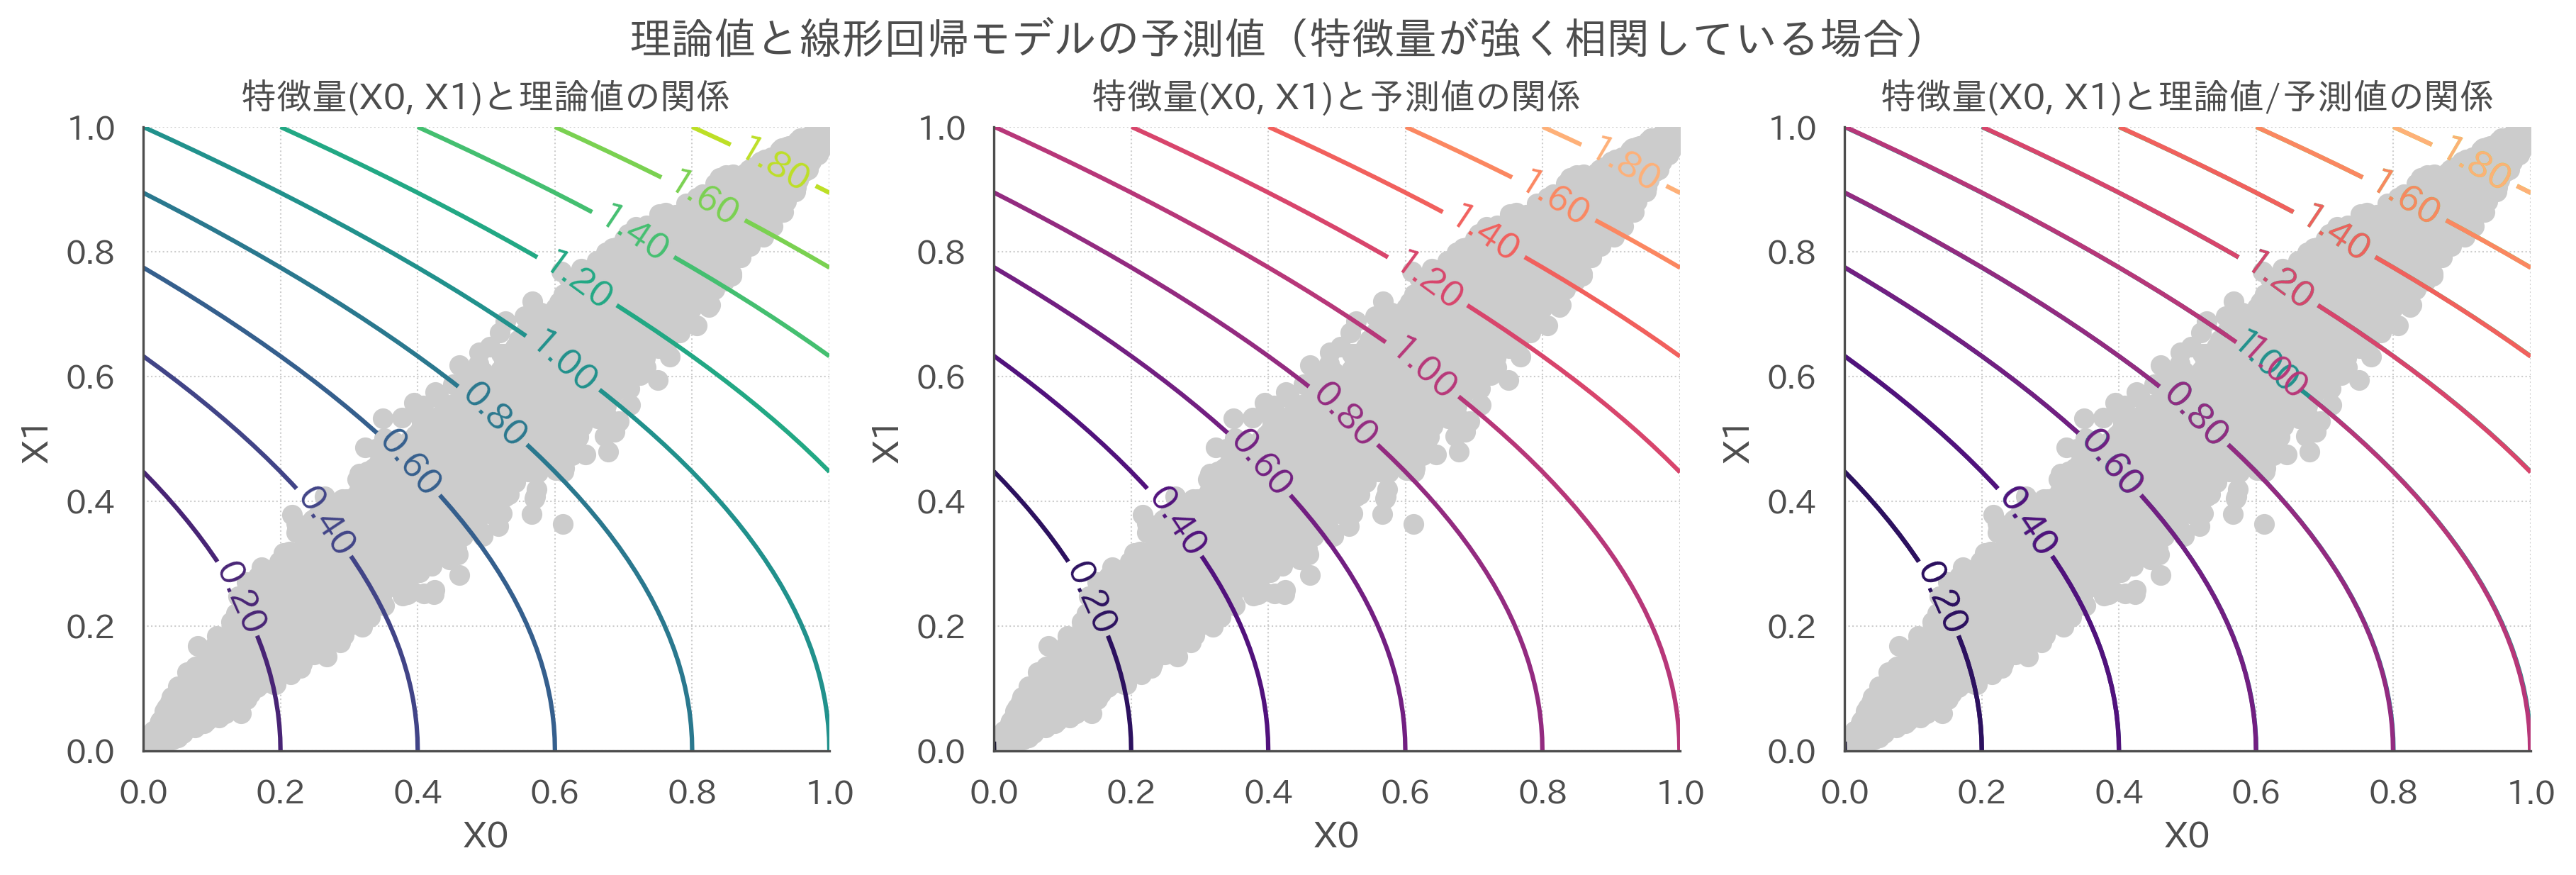

In [17]:
# 線形回帰モデルの予測値と理論値の比較
draw_contours(X=X, model=lm, title="理論値と線形回帰モデルの予測値（特徴量が強く相関している場合）")

この線形回帰モデルはデータの存在しない範囲においても理論的な関係を完璧に学習できていて、外挿がうまくいっていることがわかります。

この場合、PDでも理論的な関係を復元することができます。

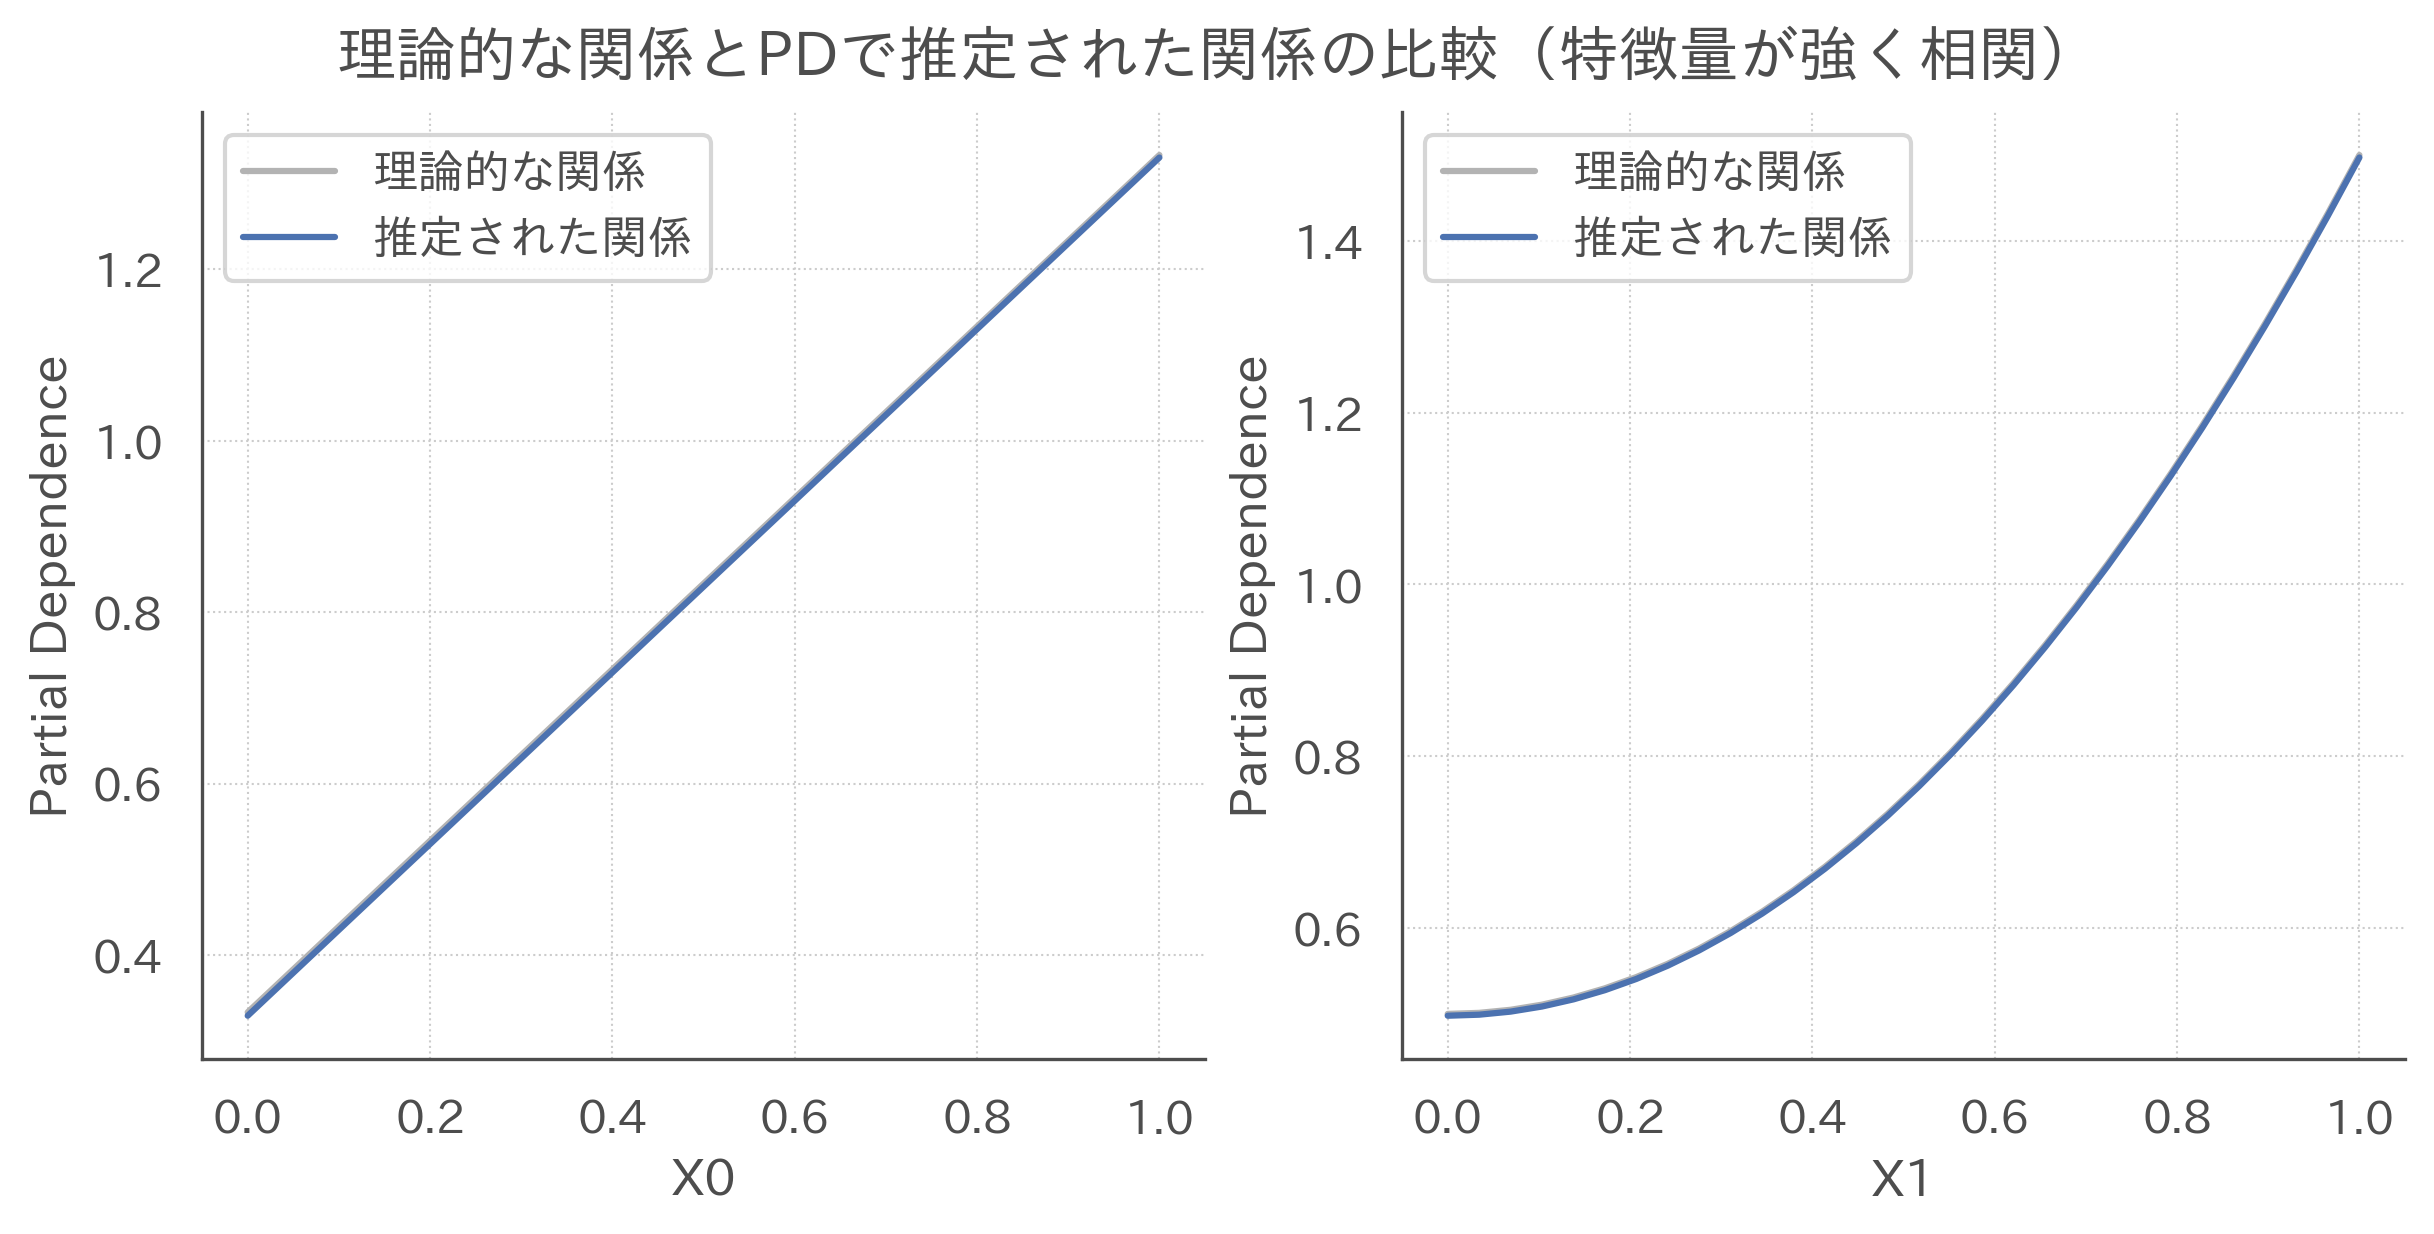

In [18]:
# インスタンスを作成
pd = PartialDependence(lm, X)

# PDを可視化
fs = [lambda x: x + 1 / 3, lambda x: x ** 2 + 0.5]
pd.plot(fs=fs, ylabel="Partial Dependence", title="理論的な関係とPDで推定された関係の比較（特徴量が強く相関）")

このように、モデルがデータの存在しない範囲においてもうまく予測ができる場合は、たとえ特徴量に強い相関があってもPDで理論的な関係を復元することができます。
ただ、線形回帰モデルで特定化に完璧に成功した場合など、かなりレアなケースでしかこの状況は成立しません。
Random ForestやNeural Netなどのフレキシブルなモデルを利用すると外挿がうまくいかないことが多いので、特徴量が強く相関する場合はALEを使うことが無難と言えます。

## 参考文献

- Apley, Daniel W., and Jingyu Zhu. "Visualizing the effects of predictor variables in black box supervised learning models." Journal of the Royal Statistical Society: Series B (Statistical Methodology) 82.4 (2020): 1059-1086.
- Molnar, Christoph. "Interpretable machine learning. A Guide for Making Black Box Models Explainable." (2019). https://christophm.github.io/interpretable-ml-book/.
- Limitations of Interpretable Machine Learning Methods: https://compstat-lmu.github.io/iml_methods_limitations/.
- 森下光之助. 「機械学習を解釈する技術〜予測力と説明力を両立する実践テクニック」. 技術評論社. (2021).